In [45]:
! pip install keras_preprocessing
import tensorflow as tf 
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix

import os
from sklearn.model_selection import KFold
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

!pip install nltk
import nltk
nltk.download('all')
nltk.download('stopwords')
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree


from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()
uploaded3 = files.upload()
uploaded4 = files.upload()
import io


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

Saving X_train.csv to X_train.csv


Saving y_train.csv to y_train.csv


Saving X_test.csv to X_test (3).csv


Saving y_test.csv to y_test (3).csv


In [46]:

x_train_df = pd.read_csv(io.BytesIO(uploaded1['X_train.csv']))
y_train_df = pd.read_csv(io.BytesIO(uploaded2['y_train.csv']))

df = pd.DataFrame(index=range(len(x_train_df)),columns=["Facts","winner_index","first_party","second_party"])

for i in range (len(df)):
    df['Facts'].iloc[i] = x_train_df['Facts'].iloc[i]
    df['first_party'].iloc[i] = x_train_df['first_party'].iloc[i]
    df['second_party'].iloc[i] = x_train_df['second_party'].iloc[i]
    df['winner_index'].iloc[i] = y_train_df['winner_index'].iloc[i].item()
    
x_prediction_df = pd.read_csv(io.BytesIO(uploaded3['X_test.csv']))
y_prediction_df = pd.read_csv(io.BytesIO(uploaded4['y_test.csv']))

df_pred = pd.DataFrame(index=range(len(x_prediction_df)),columns=["Facts","winner_index","first_party","second_party"])

for i in range (len(df_pred)):
    df_pred['Facts'].iloc[i] = x_prediction_df['Facts'].iloc[i]
    df_pred['first_party'].iloc[i] = x_prediction_df['first_party'].iloc[i]
    df_pred['second_party'].iloc[i] = x_prediction_df['second_party'].iloc[i]
    df_pred['winner_index'].iloc[i] = y_prediction_df['winner_index'].iloc[i].item()
    
print(df.shape , df_pred.shape)
        
df.head()

(2771, 4) (693, 4)


,Facts,winner_index,first_party,second_party
0,"On March 26, 1971, the proprietor of a Rochest...",0,Irving Jerome Dunaway,State of New York
1,This case represents another chapter in the lo...,0,Kansas,Colorado
2,The Pole Attachments Act requires the Federal ...,0,National Cable and Telecommunications Association,Gulf Power Company
3,"The plaintiffs, employees of the Union Pacific...",1,Union Pacific Railroad Company,Brotherhood of Locomotive Engineers and Trainm...
4,Lois Davis was an information technology ( IT ...,1,"Fort Bend County, Texas",Lois M. Davis


In [47]:
# The maximum number of words to be used. (most frequent)

#MAX_NB_WORDS = 18430

# Max number of words in each sample.
#MAX_SEQUENCE_LENGTH = 250

# This is fixed.
EMBEDDING_DIM = 100

#tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer=Tokenizer()

def MAX_NB_WORDS_func (d__f):
    tokenizer.fit_on_texts(d__f['Facts'].values)
    MAX_NB_WORDS = len(tokenizer.word_index)+1
    return MAX_NB_WORDS

def max_seq_length_func (d__f):
    
    max_seq_length = 0
    j = 0
    
    for i in range(len(d__f)):
        if (len(d__f['Facts'].iloc[i].split())) > max_seq_length :
            max_seq_length = len(d__f['Facts'].iloc[i].split())
        if max_seq_length > 974 :
            j=j+1
    
    return max_seq_length , j

max_1_words = MAX_NB_WORDS_func(df)
max_2_words = MAX_NB_WORDS_func(df_pred)

max_1_seq , j_1 = max_seq_length_func(df)
max_2_seq , j_2 = max_seq_length_func(df_pred)


print(max_1_words , max_2_words)
print (max_1_seq , j_1 , max_2_seq , j_2)



18430 20387
974 0 522 0


In [48]:
MAX_SEQUENCE_LENGTH = 974
MAX_NUM_WORDS = 18430

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [49]:
# function for padding train & testing dataframes :

def padding_df (d__f):
    
    X = d__f.Facts
    Y = d__f.winner_index
    le = LabelEncoder()
    Y = le.fit_transform(Y)
    Y = Y.reshape(-1,1)
    
    tok = Tokenizer(num_words=MAX_NUM_WORDS)
    tok.fit_on_texts(X)
    sequences = tok.texts_to_sequences(X)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
    
    return sequences_matrix , Y

In [50]:
def K_fold (train_data):
    n=4
    i=0
    kf = KFold(n_splits=n, random_state=42, shuffle=True)
    
    for train_index, val_index in kf.split(train_data):
        
        # splitting Dataframe (dataset not included)
        i=i+1
        train_df = train_data.iloc[train_index]
        val_df = train_data.iloc[val_index]
        
        if i ==1 :
            train_1 = train_df
            test_1 = val_df
            
        if i ==2 :
            train_2 = train_df
            test_2 = val_df
        if i ==3 :
            train_3 = train_df
            test_3 = val_df
        if i ==4 :
            train_4 = train_df
            test_4 = val_df
           
    return train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4
        

In [51]:
epochs = 7
batch_size = 32

In [52]:
# function that create the model :

def creating_model (x_train,y_train,x_val,y_val,x_test,y_test):
    
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_NUM_WORDS , 100 ,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
    
    hist = model.fit(x_train , y_train, validation_data= (x_val , y_val) , batch_size = batch_size ,epochs = epochs)
    
    # Accuracy graph
    plt.title('Accuracy')
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.legend()
    plt.show()
    
    # Loss graph
    plt.title('Loss')
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    
    print('Testing model : /n')
    accr = model.evaluate(x_test,y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

    return model


In [53]:
# preprocessing function 

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


def preprocessing (d__f):
    for samplee in range(len(d__f)):
        d__f['Facts'].iloc[samplee]=clean_text(d__f['Facts'].iloc[samplee])
        
    return d__f

In [54]:
def balancing_func (d__f):
    r=0
    while r<611:
        i=random.randrange(len(d__f))
        if d__f['winner_index'].iloc[i] == 0:
            d__f=d__f.drop([d__f.index[i]])
            r=r+1
    return d__f

In [55]:
def anonymisation (text , first_party , second_party):
    
    first_words = first_party.split()
    second_words = second_party.split()
    
    nltk_results = ne_chunk(pos_tag(word_tokenize(text)))
    
    for nltk_result in nltk_results:
        if type(nltk_result) == Tree:
            name = ''
            for nltk_result_leaf in nltk_result.leaves():
                name += nltk_result_leaf[0] + ' '
        
                #print ('Type: ', nltk_result.label(), 'Name: ', name)
                if nltk_result.label() != 'PERSON':
                    text = text.replace(name,'anonymized')
            
    text = text.replace(first_party ,'first_party') 
    text = text.replace(second_party , 'second_party')
    for f_w in first_words:
        text = text.replace(f_w , 'first_party')
    for s_w in second_words :
        text = text.replace(s_w , 'second_party')
                            
    return text

In [56]:
probabilities= []

2078 693
693
Epoch 1/7
59/59 [==============================] - 4s 41ms/step - loss: 0.6367 - accuracy: 0.6503 - val_loss: 0.5065 - val_accuracy: 0.8462
Epoch 2/7
59/59 [==============================] - 2s 33ms/step - loss: 0.2427 - accuracy: 0.9144 - val_loss: 0.1984 - val_accuracy: 0.9279
Epoch 3/7
59/59 [==============================] - 2s 35ms/step - loss: 0.0826 - accuracy: 0.9743 - val_loss: 0.1828 - val_accuracy: 0.9423
Epoch 4/7
59/59 [==============================] - 2s 30ms/step - loss: 0.0317 - accuracy: 0.9909 - val_loss: 0.1538 - val_accuracy: 0.9471
Epoch 5/7
59/59 [==============================] - 2s 30ms/step - loss: 0.0240 - accuracy: 0.9925 - val_loss: 0.1460 - val_accuracy: 0.9663
Epoch 6/7
59/59 [==============================] - 2s 30ms/step - loss: 1.3455e-04 - accuracy: 1.0000 - val_loss: 0.1241 - val_accuracy: 0.9663
Epoch 7/7
59/59 [==============================] - 2s 30ms/step - loss: 1.1898e-05 - accuracy: 1.0000 - val_loss: 0.2430 - val_accuracy: 0.9663

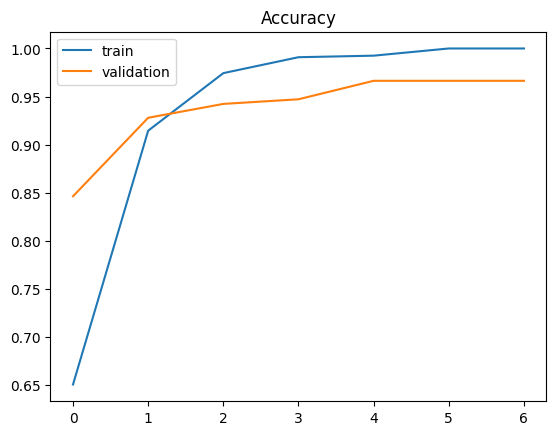

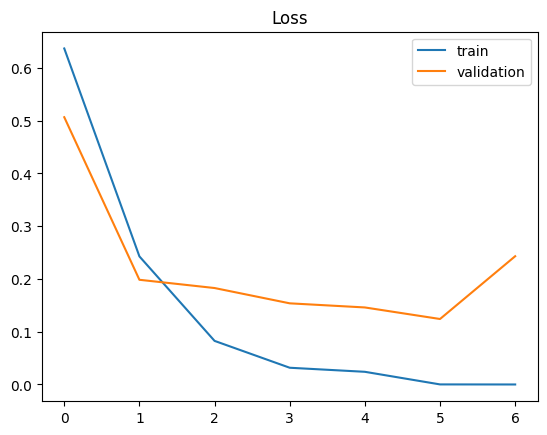

Testing model : /n
22/22 [==============================] - 1s 22ms/step - loss: 4.6420 - accuracy: 0.5310
Test set
  Loss: 4.642
  Accuracy: 0.531
22/22 [==============================] - 1s 12ms/step


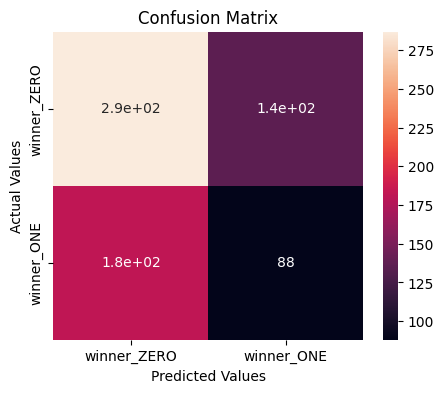

classification_report
               precision    recall  f1-score   support

           0       0.61      0.68      0.64       423
           1       0.39      0.33      0.36       270

    accuracy                           0.54       693
   macro avg       0.50      0.50      0.50       693
weighted avg       0.53      0.54      0.53       693

Epoch 1/7
59/59 [==============================] - 4s 43ms/step - loss: 0.6392 - accuracy: 0.6695 - val_loss: 0.5073 - val_accuracy: 0.7885
Epoch 2/7
59/59 [==============================] - 2s 40ms/step - loss: 0.3162 - accuracy: 0.8866 - val_loss: 0.3363 - val_accuracy: 0.8654
Epoch 3/7
59/59 [==============================] - 2s 32ms/step - loss: 0.1055 - accuracy: 0.9658 - val_loss: 0.3057 - val_accuracy: 0.8846
Epoch 4/7
59/59 [==============================] - 2s 30ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.2274 - val_accuracy: 0.9471
Epoch 5/7
59/59 [==============================] - 2s 31ms/step - loss: 0.0179 - accuracy:

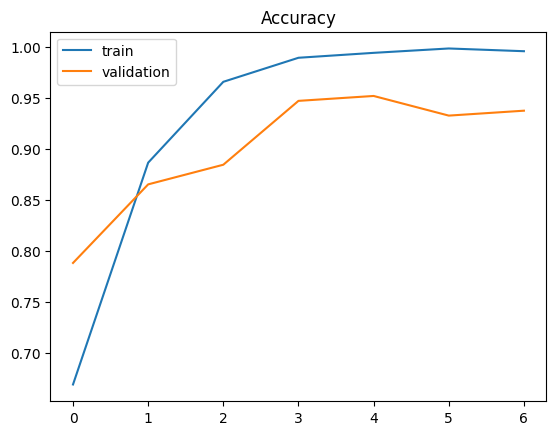

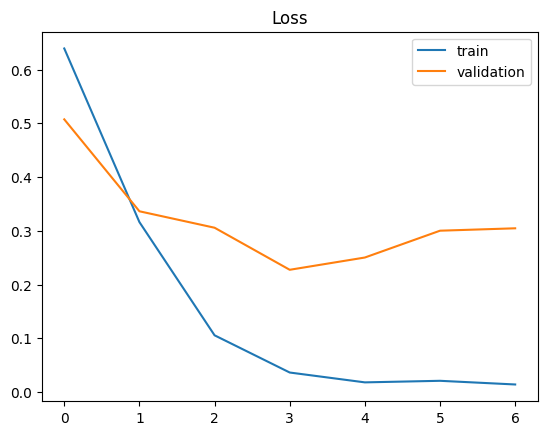

Testing model : /n
22/22 [==============================] - 1s 37ms/step - loss: 2.1262 - accuracy: 0.5743
Test set
  Loss: 2.126
  Accuracy: 0.574
22/22 [==============================] - 1s 27ms/step


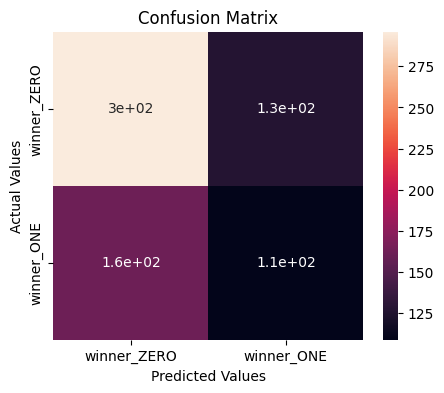

classification_report
               precision    recall  f1-score   support

           0       0.65      0.70      0.67       423
           1       0.46      0.40      0.43       270

    accuracy                           0.58       693
   macro avg       0.55      0.55      0.55       693
weighted avg       0.58      0.58      0.58       693

Epoch 1/7
59/59 [==============================] - 5s 54ms/step - loss: 0.6465 - accuracy: 0.6305 - val_loss: 0.5223 - val_accuracy: 0.8029
Epoch 2/7
59/59 [==============================] - 2s 32ms/step - loss: 0.2563 - accuracy: 0.9187 - val_loss: 0.2168 - val_accuracy: 0.9375
Epoch 3/7
59/59 [==============================] - 2s 32ms/step - loss: 0.1452 - accuracy: 0.9663 - val_loss: 0.1876 - val_accuracy: 0.9567
Epoch 4/7
59/59 [==============================] - 2s 32ms/step - loss: 0.0384 - accuracy: 0.9898 - val_loss: 0.2252 - val_accuracy: 0.9327
Epoch 5/7
59/59 [==============================] - 2s 31ms/step - loss: 0.0050 - accuracy:

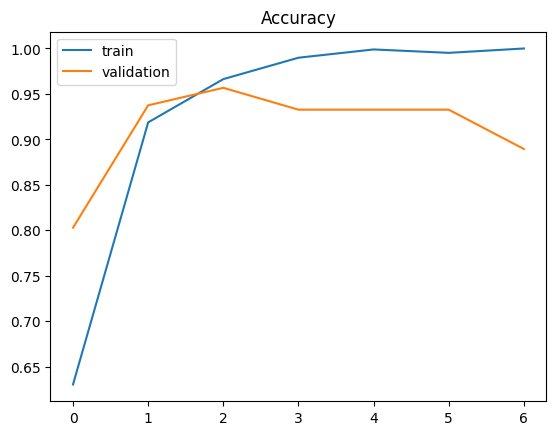

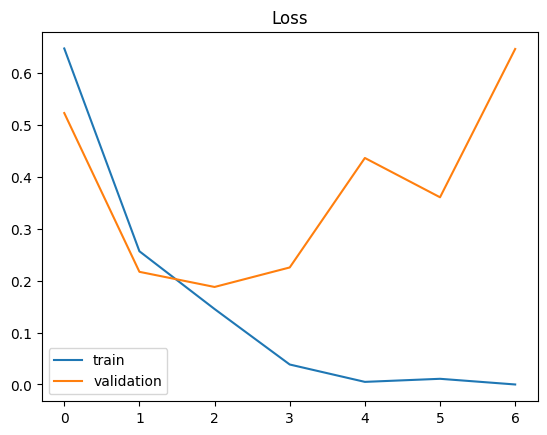

Testing model : /n
22/22 [==============================] - 0s 18ms/step - loss: 4.2555 - accuracy: 0.5051
Test set
  Loss: 4.256
  Accuracy: 0.505
22/22 [==============================] - 1s 12ms/step


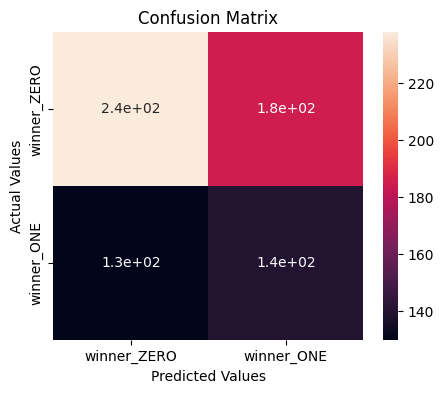

classification_report
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       423
           1       0.43      0.52      0.47       270

    accuracy                           0.55       693
   macro avg       0.54      0.54      0.54       693
weighted avg       0.56      0.55      0.55       693

Epoch 1/7
59/59 [==============================] - 4s 43ms/step - loss: 0.6277 - accuracy: 0.6676 - val_loss: 0.3307 - val_accuracy: 0.8654
Epoch 2/7
59/59 [==============================] - 2s 32ms/step - loss: 0.2575 - accuracy: 0.9059 - val_loss: 0.1894 - val_accuracy: 0.9375
Epoch 3/7
59/59 [==============================] - 2s 33ms/step - loss: 0.0846 - accuracy: 0.9749 - val_loss: 0.2150 - val_accuracy: 0.9135
Epoch 4/7
59/59 [==============================] - 2s 41ms/step - loss: 0.0271 - accuracy: 0.9925 - val_loss: 0.1229 - val_accuracy: 0.9615
Epoch 5/7
59/59 [==============================] - 2s 33ms/step - loss: 0.1266 - accuracy:

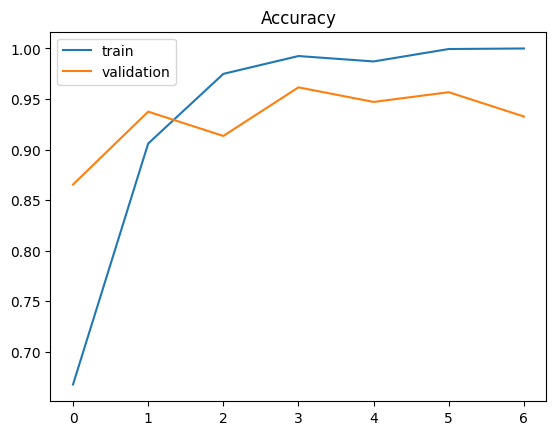

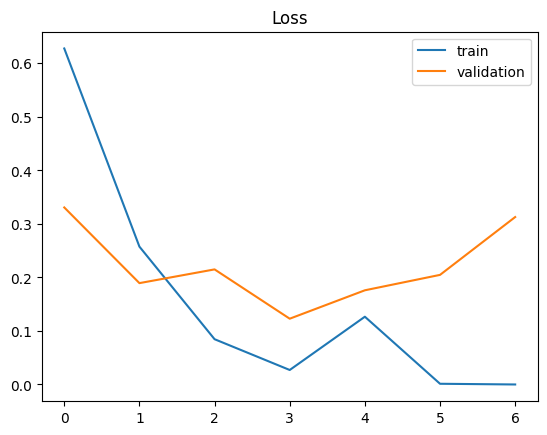

Testing model : /n
22/22 [==============================] - 0s 15ms/step - loss: 4.4005 - accuracy: 0.5116
Test set
  Loss: 4.400
  Accuracy: 0.512
22/22 [==============================] - 1s 12ms/step


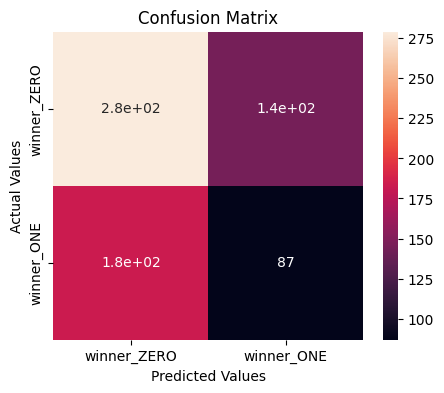

classification_report
               precision    recall  f1-score   support

           0       0.60      0.66      0.63       423
           1       0.38      0.32      0.35       270

    accuracy                           0.53       693
   macro avg       0.49      0.49      0.49       693
weighted avg       0.52      0.53      0.52       693

Acuuracy results of the 4 models :  [0.5411255411255411, 0.5844155844155844, 0.5454545454545454, 0.5281385281385281]
Avrage accuracy of this probability = 0.5497835497835498


In [57]:
# No preprocessing-NO Balancing-No Anonymisation (1)

dff=df
dff_pred = df_pred
#-----------------------------------

train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4 = K_fold(dff)

#----------------------------------
print(len (train_1),len(test_1))
x_1 , y_1 = padding_df(train_1)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1,y_1, test_size = 0.1, random_state = 42)
x_test_1 , y_test_1 = padding_df(test_1)

x_2 , y_2 = padding_df(train_2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2,y_2, test_size = 0.1, random_state = 42)
x_test_2 , y_test_2 = padding_df(test_2)

x_3 , y_3 = padding_df(train_3)
x_train_3 , x_val_3, y_train_3, y_val_3 = train_test_split(x_3,y_3, test_size = 0.1, random_state = 42)
x_test_3 , y_test_3 = padding_df(test_3)

x_4 , y_4 = padding_df(train_4)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_4,y_4, test_size = 0.1, random_state = 42)
x_test_4 , y_test_4 = padding_df(test_4)

#------------------------------------

x_prediction , target_labels = padding_df(dff_pred)
print(len(x_prediction))

acc_result = []

for i in range (4):
    
    if i == 0 :
        the_model_1_1 = creating_model( x_train_1 , y_train_1 , x_val_1 , y_val_1, x_test_1 , y_test_1)
        
        y_predict = the_model_1_1.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 1 :
        the_model_1_2 = creating_model( x_train_2 , y_train_2 , x_val_2 , y_val_2, x_test_2 , y_test_2)
        
        y_predict = the_model_1_2.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 2 :
        the_model_1_3 = creating_model( x_train_3 , y_train_3 , x_val_3 , y_val_3, x_test_3 , y_test_3)
        
        y_predict = the_model_1_3.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 3 :
        the_model_1_4 = creating_model( x_train_4 , y_train_4 , x_val_4 , y_val_4, x_test_4 , y_test_4)
        
        y_predict = the_model_1_4.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
print('Acuuracy results of the 4 models : ',acc_result)
print('Avrage accuracy of this probability =' , sum(acc_result)/len(acc_result))

probabilities.append(sum(acc_result)/len(acc_result))

Epoch 1/7
59/59 [==============================] - 7s 67ms/step - loss: 0.6311 - accuracy: 0.6636 - val_loss: 0.4078 - val_accuracy: 0.8558
Epoch 2/7
59/59 [==============================] - 2s 38ms/step - loss: 0.2521 - accuracy: 0.9112 - val_loss: 0.1597 - val_accuracy: 0.9615
Epoch 3/7
59/59 [==============================] - 3s 47ms/step - loss: 0.0724 - accuracy: 0.9749 - val_loss: 0.2754 - val_accuracy: 0.8942
Epoch 4/7
59/59 [==============================] - 3s 45ms/step - loss: 0.0436 - accuracy: 0.9845 - val_loss: 0.1296 - val_accuracy: 0.9615
Epoch 5/7
59/59 [==============================] - 2s 38ms/step - loss: 0.0256 - accuracy: 0.9973 - val_loss: 0.4856 - val_accuracy: 0.8702
Epoch 6/7
59/59 [==============================] - 2s 38ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1468 - val_accuracy: 0.9712
Epoch 7/7
59/59 [==============================] - 2s 38ms/step - loss: 2.3989e-05 - accuracy: 1.0000 - val_loss: 0.1607 - val_accuracy: 0.9760


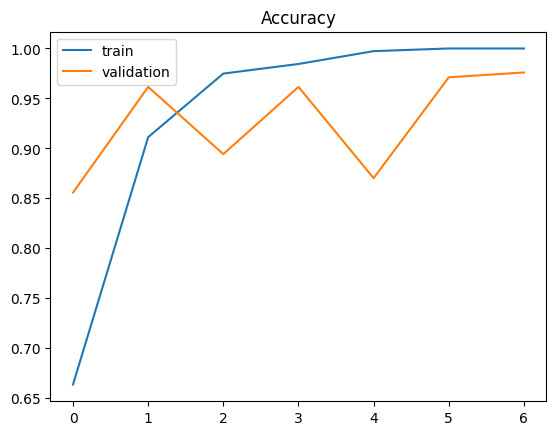

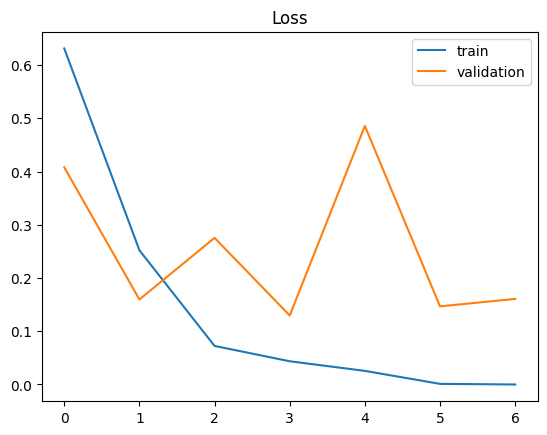

Testing model : /n
22/22 [==============================] - 0s 17ms/step - loss: 3.2903 - accuracy: 0.6133
Test set
  Loss: 3.290
  Accuracy: 0.613
22/22 [==============================] - 1s 16ms/step


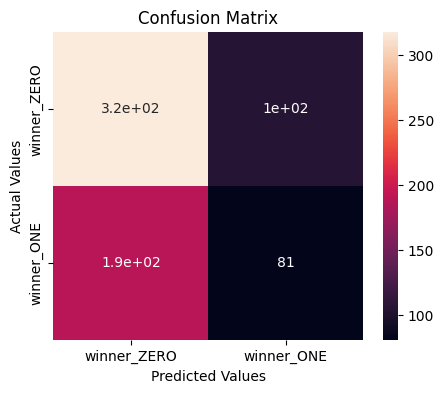

classification_report
               precision    recall  f1-score   support

           0       0.63      0.75      0.68       423
           1       0.44      0.30      0.36       270

    accuracy                           0.58       693
   macro avg       0.53      0.53      0.52       693
weighted avg       0.55      0.58      0.56       693

Epoch 1/7
59/59 [==============================] - 6s 55ms/step - loss: 0.6402 - accuracy: 0.6572 - val_loss: 0.5030 - val_accuracy: 0.7692
Epoch 2/7
59/59 [==============================] - 2s 39ms/step - loss: 0.3101 - accuracy: 0.8898 - val_loss: 0.3782 - val_accuracy: 0.8510
Epoch 3/7
59/59 [==============================] - 3s 58ms/step - loss: 0.1280 - accuracy: 0.9610 - val_loss: 0.4620 - val_accuracy: 0.8846
Epoch 4/7
59/59 [==============================] - 2s 40ms/step - loss: 0.0564 - accuracy: 0.9845 - val_loss: 0.2329 - val_accuracy: 0.9471
Epoch 5/7
59/59 [==============================] - 2s 40ms/step - loss: 0.0671 - accuracy:

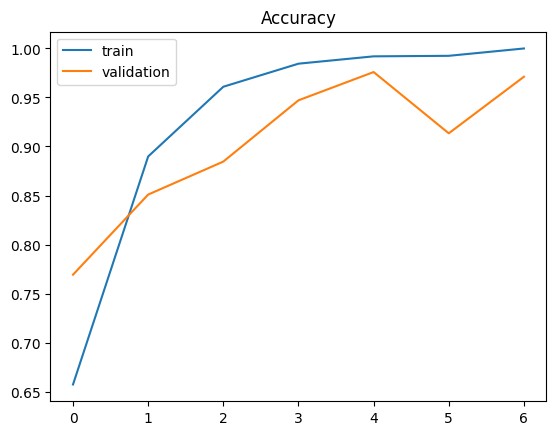

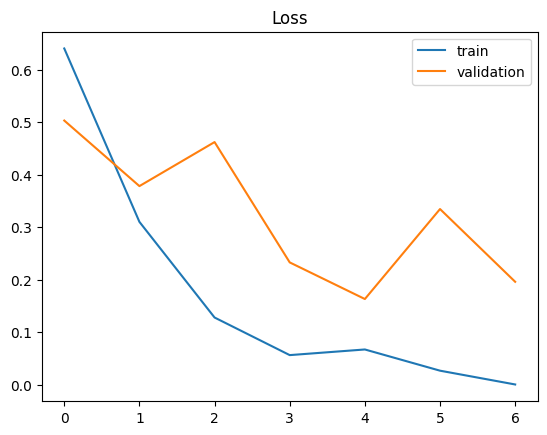

Testing model : /n
22/22 [==============================] - 0s 20ms/step - loss: 3.4801 - accuracy: 0.5426
Test set
  Loss: 3.480
  Accuracy: 0.543
22/22 [==============================] - 1s 11ms/step


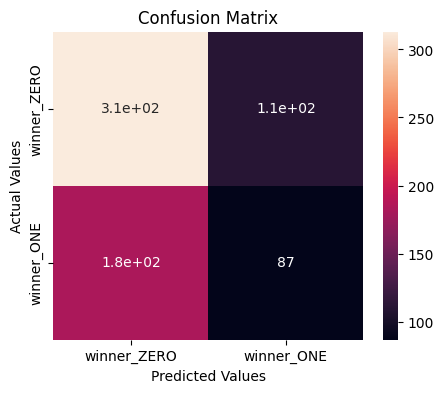

classification_report
               precision    recall  f1-score   support

           0       0.63      0.74      0.68       423
           1       0.44      0.32      0.37       270

    accuracy                           0.58       693
   macro avg       0.54      0.53      0.53       693
weighted avg       0.56      0.58      0.56       693

Epoch 1/7
59/59 [==============================] - 4s 41ms/step - loss: 0.6539 - accuracy: 0.6561 - val_loss: 1.0656 - val_accuracy: 0.6779
Epoch 2/7
59/59 [==============================] - 2s 32ms/step - loss: 0.3088 - accuracy: 0.8920 - val_loss: 0.2341 - val_accuracy: 0.9183
Epoch 3/7
59/59 [==============================] - 2s 33ms/step - loss: 0.0998 - accuracy: 0.9647 - val_loss: 0.2001 - val_accuracy: 0.9327
Epoch 4/7
59/59 [==============================] - 2s 37ms/step - loss: 0.0482 - accuracy: 0.9866 - val_loss: 0.2230 - val_accuracy: 0.9519
Epoch 5/7
59/59 [==============================] - 2s 31ms/step - loss: 0.1941 - accuracy:

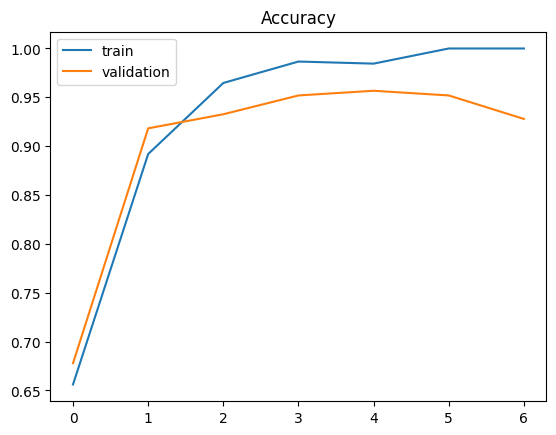

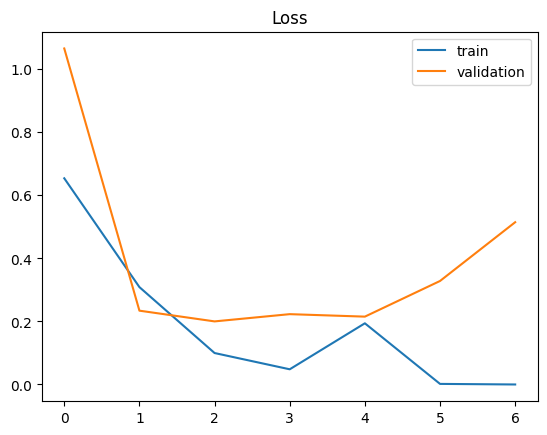

Testing model : /n
22/22 [==============================] - 0s 13ms/step - loss: 3.6707 - accuracy: 0.5541
Test set
  Loss: 3.671
  Accuracy: 0.554
22/22 [==============================] - 1s 12ms/step


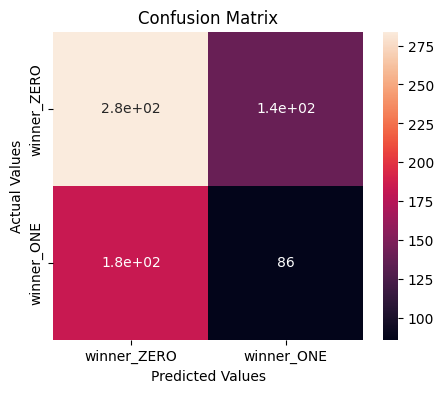

classification_report
               precision    recall  f1-score   support

           0       0.61      0.67      0.64       423
           1       0.38      0.32      0.35       270

    accuracy                           0.53       693
   macro avg       0.49      0.49      0.49       693
weighted avg       0.52      0.53      0.52       693

Epoch 1/7
59/59 [==============================] - 5s 50ms/step - loss: 0.6308 - accuracy: 0.6526 - val_loss: 0.5177 - val_accuracy: 0.8029
Epoch 2/7
59/59 [==============================] - 2s 31ms/step - loss: 0.2920 - accuracy: 0.9049 - val_loss: 0.2385 - val_accuracy: 0.9135
Epoch 3/7
59/59 [==============================] - 2s 32ms/step - loss: 0.0942 - accuracy: 0.9690 - val_loss: 0.5206 - val_accuracy: 0.8413
Epoch 4/7
59/59 [==============================] - 2s 31ms/step - loss: 0.0473 - accuracy: 0.9861 - val_loss: 0.9096 - val_accuracy: 0.7115
Epoch 5/7
59/59 [==============================] - 2s 32ms/step - loss: 0.0202 - accuracy:

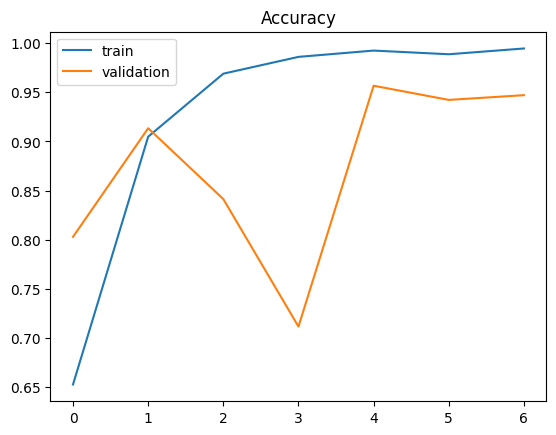

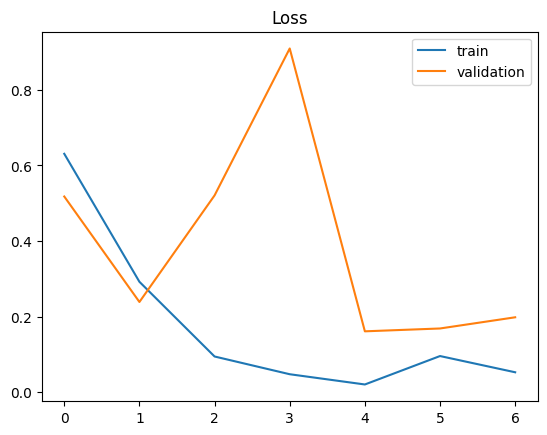

Testing model : /n
22/22 [==============================] - 0s 21ms/step - loss: 3.0647 - accuracy: 0.5665
Test set
  Loss: 3.065
  Accuracy: 0.566
22/22 [==============================] - 1s 12ms/step


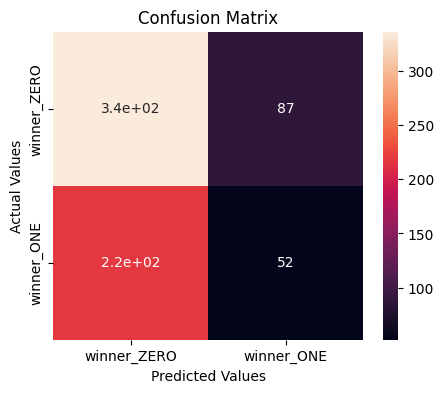

classification_report
               precision    recall  f1-score   support

           0       0.61      0.79      0.69       423
           1       0.37      0.19      0.25       270

    accuracy                           0.56       693
   macro avg       0.49      0.49      0.47       693
weighted avg       0.52      0.56      0.52       693

Acuuracy results of the 4 models :  [0.5757575757575758, 0.5772005772005772, 0.5339105339105339, 0.5598845598845599]
Avrage accuracy of this probability = 0.5616883116883117


In [58]:
# No preprocessing-NO Balancing- Anonymisation (2)

dff = df
dff_pred = df_pred

for i in range (len(dff)):
    dff['Facts'].iloc[i] = anonymisation(dff['Facts'].iloc[i] , dff['first_party'].iloc[i] , dff['second_party'].iloc[i])

for i in range (len(dff_pred)):
    dff_pred['Facts'].iloc[i] = anonymisation(dff_pred['Facts'].iloc[i], dff_pred['first_party'].iloc[i] , dff_pred['second_party'].iloc[i])

#-----------------------------------

train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4 = K_fold(dff)

#----------------------------------

x_1 , y_1 = padding_df(train_1)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1,y_1, test_size = 0.1, random_state = 42)
x_test_1 , y_test_1 = padding_df(test_1)

x_2 , y_2 = padding_df(train_2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2,y_2, test_size = 0.1, random_state = 42)
x_test_2 , y_test_2 = padding_df(test_2)

x_3 , y_3 = padding_df(train_3)
x_train_3 , x_val_3, y_train_3, y_val_3 = train_test_split(x_3,y_3, test_size = 0.1, random_state = 42)
x_test_3 , y_test_3 = padding_df(test_3)

x_4 , y_4 = padding_df(train_4)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_4,y_4, test_size = 0.1, random_state = 42)
x_test_4 , y_test_4 = padding_df(test_4)

#------------------------------------
x_prediction , target_labels = padding_df(dff_pred)

acc_result = []

for i in range (4):
    
    if i == 0 :
        the_model_2_1 = creating_model( x_train_1 , y_train_1 , x_val_1 , y_val_1, x_test_1 , y_test_1)
        
        y_predict = the_model_2_1.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 1 :
        the_model_2_2 = creating_model( x_train_2 , y_train_2 , x_val_2 , y_val_2, x_test_2 , y_test_2)
        
        y_predict = the_model_2_2.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 2 :
        the_model_2_3 = creating_model( x_train_3 , y_train_3 , x_val_3 , y_val_3, x_test_3 , y_test_3)
        
        y_predict = the_model_2_3.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 3 :
        the_model_2_4 = creating_model( x_train_4 , y_train_4 , x_val_4 , y_val_4, x_test_4 , y_test_4)
        
        y_predict = the_model_2_4.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
print('Acuuracy results of the 4 models : ',acc_result)
print('Avrage accuracy of this probability =' , sum(acc_result)/len(acc_result))

probabilities.append(sum(acc_result)/len(acc_result))



Epoch 1/7
41/41 [==============================] - 5s 50ms/step - loss: 0.7036 - accuracy: 0.6103 - val_loss: 0.5751 - val_accuracy: 0.7994
Epoch 2/7
41/41 [==============================] - 1s 32ms/step - loss: 0.3897 - accuracy: 0.8603 - val_loss: 0.3195 - val_accuracy: 0.8765
Epoch 3/7
41/41 [==============================] - 1s 31ms/step - loss: 0.1429 - accuracy: 0.9522 - val_loss: 0.4322 - val_accuracy: 0.8364
Epoch 4/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0583 - accuracy: 0.9823 - val_loss: 0.2968 - val_accuracy: 0.8981
Epoch 5/7
41/41 [==============================] - 1s 31ms/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.3812 - val_accuracy: 0.9043
Epoch 6/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0099 - accuracy: 0.9977 - val_loss: 0.3863 - val_accuracy: 0.9136
Epoch 7/7
41/41 [==============================] - 1s 31ms/step - loss: 3.9381e-04 - accuracy: 1.0000 - val_loss: 0.5551 - val_accuracy: 0.9043


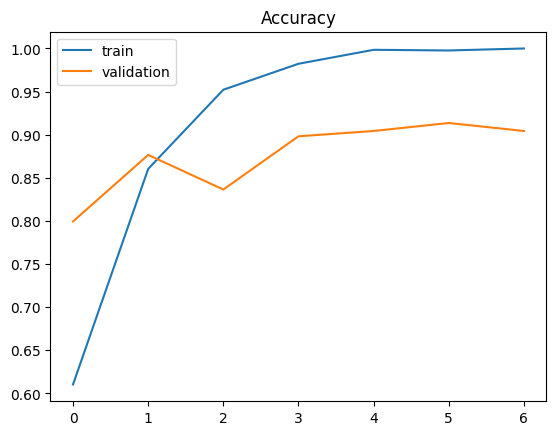

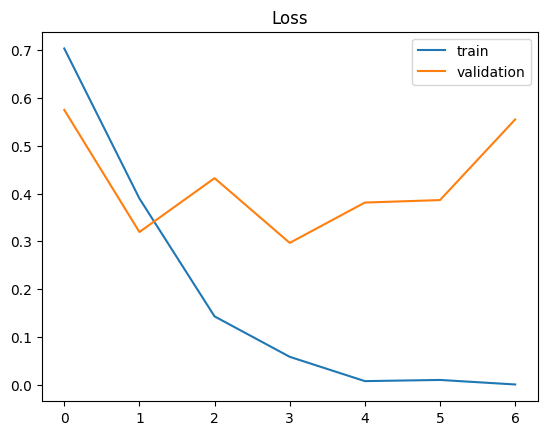

Testing model : /n
17/17 [==============================] - 0s 17ms/step - loss: 3.0628 - accuracy: 0.5389
Test set
  Loss: 3.063
  Accuracy: 0.539
22/22 [==============================] - 1s 15ms/step


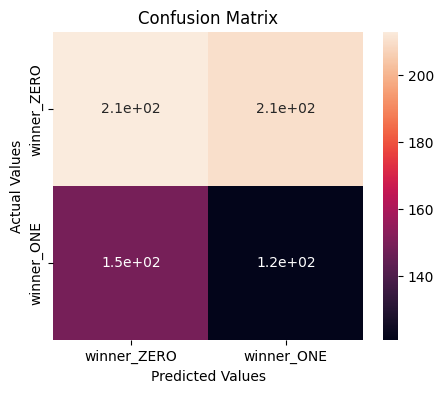

classification_report
               precision    recall  f1-score   support

           0       0.59      0.50      0.54       423
           1       0.37      0.45      0.40       270

    accuracy                           0.48       693
   macro avg       0.48      0.48      0.47       693
weighted avg       0.50      0.48      0.49       693

Epoch 1/7
41/41 [==============================] - 4s 51ms/step - loss: 0.6910 - accuracy: 0.6026 - val_loss: 0.5933 - val_accuracy: 0.7531
Epoch 2/7
41/41 [==============================] - 1s 32ms/step - loss: 0.4190 - accuracy: 0.8410 - val_loss: 0.4939 - val_accuracy: 0.7747
Epoch 3/7
41/41 [==============================] - 1s 32ms/step - loss: 0.2306 - accuracy: 0.9360 - val_loss: 0.3004 - val_accuracy: 0.8981
Epoch 4/7
41/41 [==============================] - 1s 32ms/step - loss: 0.1200 - accuracy: 0.9715 - val_loss: 0.2651 - val_accuracy: 0.9012
Epoch 5/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0355 - accuracy:

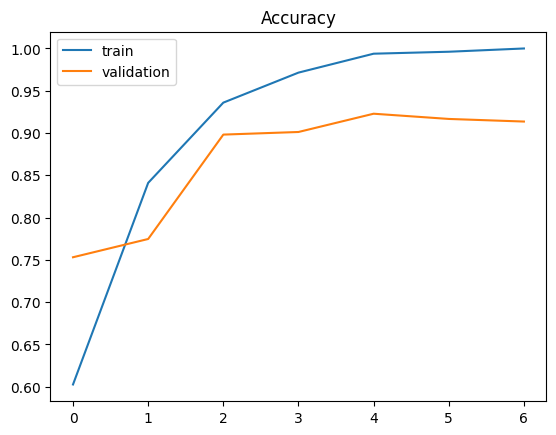

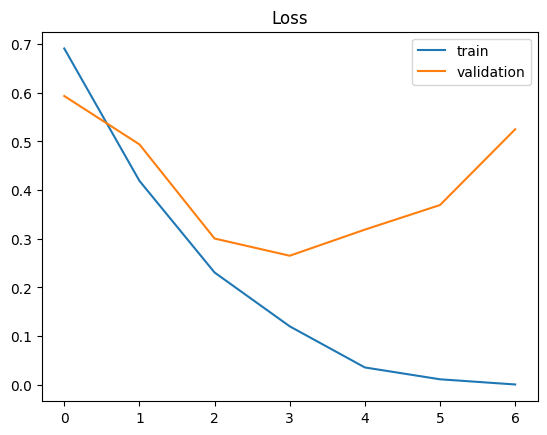

Testing model : /n
17/17 [==============================] - 0s 13ms/step - loss: 3.1429 - accuracy: 0.5426
Test set
  Loss: 3.143
  Accuracy: 0.543
22/22 [==============================] - 1s 11ms/step


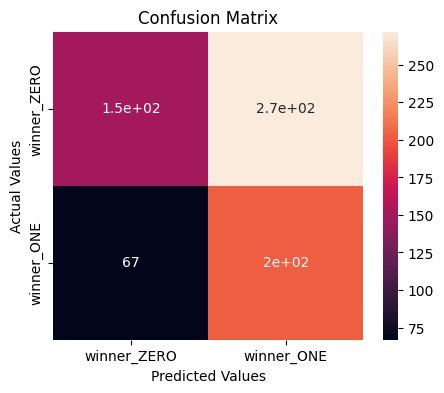

classification_report
               precision    recall  f1-score   support

           0       0.69      0.36      0.47       423
           1       0.43      0.75      0.54       270

    accuracy                           0.51       693
   macro avg       0.56      0.55      0.51       693
weighted avg       0.59      0.51      0.50       693

Epoch 1/7
41/41 [==============================] - 5s 51ms/step - loss: 0.6579 - accuracy: 0.6096 - val_loss: 0.5559 - val_accuracy: 0.7253
Epoch 2/7
41/41 [==============================] - 1s 32ms/step - loss: 0.4637 - accuracy: 0.8295 - val_loss: 0.3247 - val_accuracy: 0.8796
Epoch 3/7
41/41 [==============================] - 1s 33ms/step - loss: 0.1660 - accuracy: 0.9452 - val_loss: 0.3345 - val_accuracy: 0.8858
Epoch 4/7
41/41 [==============================] - 2s 40ms/step - loss: 0.0708 - accuracy: 0.9799 - val_loss: 0.2062 - val_accuracy: 0.9290
Epoch 5/7
41/41 [==============================] - 2s 37ms/step - loss: 0.0429 - accuracy:

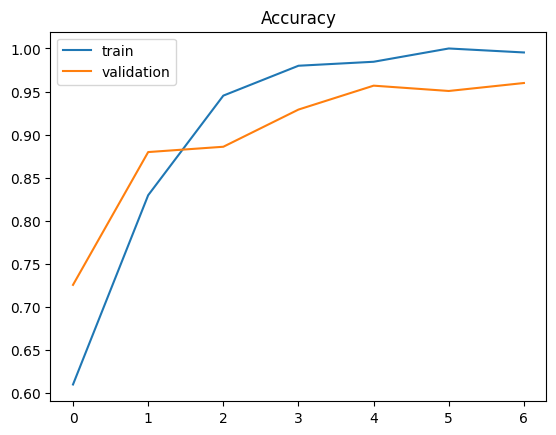

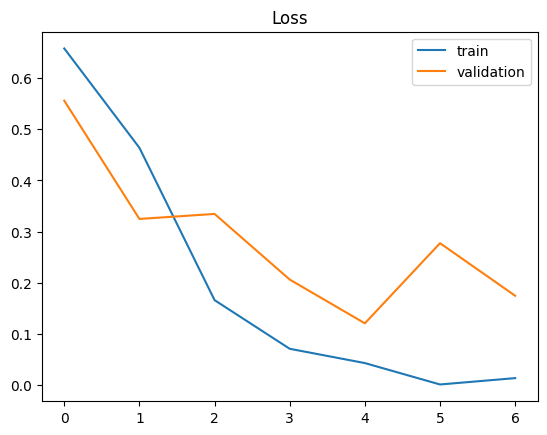

Testing model : /n
17/17 [==============================] - 0s 13ms/step - loss: 2.4821 - accuracy: 0.5759
Test set
  Loss: 2.482
  Accuracy: 0.576
22/22 [==============================] - 1s 12ms/step


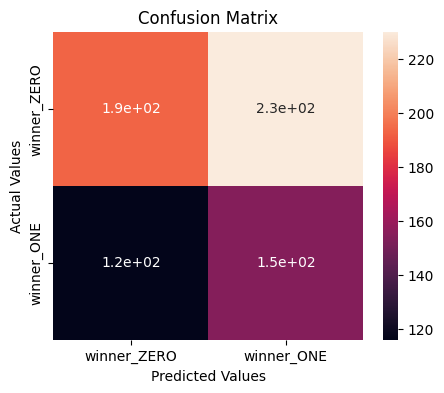

classification_report
               precision    recall  f1-score   support

           0       0.62      0.46      0.53       423
           1       0.40      0.57      0.47       270

    accuracy                           0.50       693
   macro avg       0.51      0.51      0.50       693
weighted avg       0.54      0.50      0.51       693

Epoch 1/7
41/41 [==============================] - 4s 50ms/step - loss: 0.6980 - accuracy: 0.5772 - val_loss: 0.6421 - val_accuracy: 0.7006
Epoch 2/7
41/41 [==============================] - 2s 37ms/step - loss: 0.4534 - accuracy: 0.8488 - val_loss: 0.4039 - val_accuracy: 0.8210
Epoch 3/7
41/41 [==============================] - 2s 45ms/step - loss: 0.1583 - accuracy: 0.9506 - val_loss: 0.4126 - val_accuracy: 0.7963
Epoch 4/7
41/41 [==============================] - 1s 33ms/step - loss: 0.1169 - accuracy: 0.9776 - val_loss: 0.3332 - val_accuracy: 0.8796
Epoch 5/7
41/41 [==============================] - 1s 34ms/step - loss: 0.0165 - accuracy:

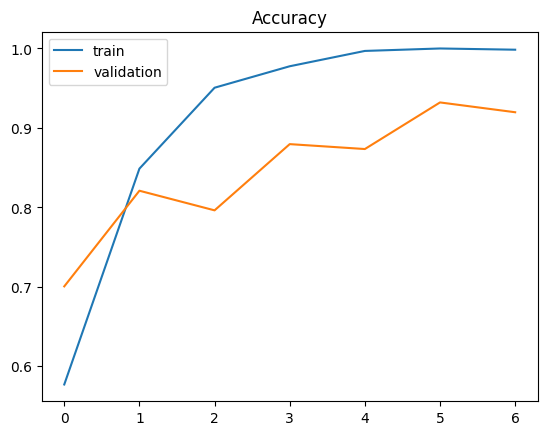

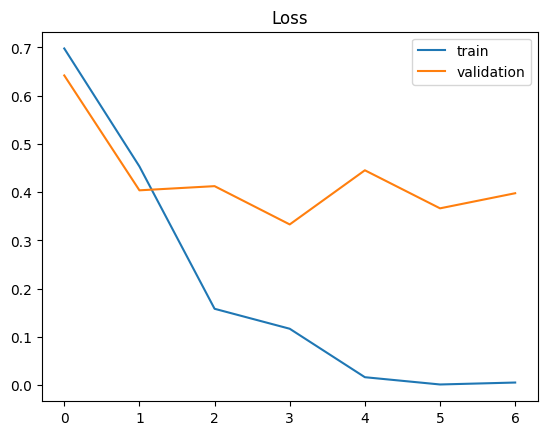

Testing model : /n
17/17 [==============================] - 0s 14ms/step - loss: 2.6398 - accuracy: 0.4796
Test set
  Loss: 2.640
  Accuracy: 0.480
22/22 [==============================] - 1s 12ms/step


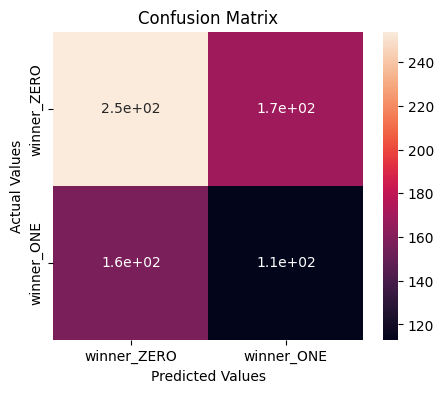

classification_report
               precision    recall  f1-score   support

           0       0.62      0.60      0.61       423
           1       0.40      0.42      0.41       270

    accuracy                           0.53       693
   macro avg       0.51      0.51      0.51       693
weighted avg       0.53      0.53      0.53       693

Acuuracy results of the 4 models :  [0.481962481962482, 0.5108225108225108, 0.5007215007215007, 0.5295815295815296]
Avrage accuracy of this probability = 0.5057720057720058


In [59]:
# No preprocessing- Balancing - No Anonymisation (3)

dff = df
dff_pred = df_pred

dff = balancing_func(dff)

#-----------------------------------

train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4 = K_fold(dff)

#----------------------------------

x_1 , y_1 = padding_df(train_1)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1,y_1, test_size = 0.2, random_state = 42)

x_test_1 , y_test_1 = padding_df(test_1)

x_2 , y_2 = padding_df(train_2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2,y_2, test_size = 0.2, random_state = 42)

x_test_2 , y_test_2 = padding_df(test_2)

x_3 , y_3 = padding_df(train_3)
x_train_3 , x_val_3, y_train_3, y_val_3 = train_test_split(x_3,y_3, test_size = 0.2, random_state = 42)

x_test_3 , y_test_3 = padding_df(test_3)

x_4 , y_4 = padding_df(train_4)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_4,y_4, test_size = 0.2, random_state = 42)

x_test_4 , y_test_4 = padding_df(test_4)

#------------------------------------
x_prediction , target_labels = padding_df(dff_pred)

acc_result = []

for i in range (4):
    
    if i == 0 :
        the_model_3_1 = creating_model( x_train_1 , y_train_1 , x_val_1 , y_val_1, x_test_1 , y_test_1)
        
        y_predict = the_model_3_1.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 1 :
        the_model_3_2 = creating_model( x_train_2 , y_train_2 , x_val_2 , y_val_2, x_test_2 , y_test_2)
        
        y_predict = the_model_3_2.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 2 :
        the_model_3_3 = creating_model( x_train_3 , y_train_3 , x_val_3 , y_val_3, x_test_3 , y_test_3)
        
        y_predict = the_model_3_3.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 3 :
        the_model_3_4 = creating_model( x_train_4 , y_train_4 , x_val_4 , y_val_4, x_test_4 , y_test_4)
        
        y_predict = the_model_3_4.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
print('Acuuracy results of the 4 models : ',acc_result)
print('Avrage accuracy of this probability =' , sum(acc_result)/len(acc_result))

probabilities.append(sum(acc_result)/len(acc_result))




Epoch 1/7
41/41 [==============================] - 4s 50ms/step - loss: 0.6861 - accuracy: 0.5718 - val_loss: 0.5919 - val_accuracy: 0.7778
Epoch 2/7
41/41 [==============================] - 1s 32ms/step - loss: 0.4047 - accuracy: 0.8395 - val_loss: 0.4575 - val_accuracy: 0.8148
Epoch 3/7
41/41 [==============================] - 1s 31ms/step - loss: 0.2617 - accuracy: 0.9267 - val_loss: 0.3328 - val_accuracy: 0.8827
Epoch 4/7
41/41 [==============================] - 1s 31ms/step - loss: 0.0668 - accuracy: 0.9730 - val_loss: 0.2938 - val_accuracy: 0.9074
Epoch 5/7
41/41 [==============================] - 2s 43ms/step - loss: 0.2334 - accuracy: 0.9792 - val_loss: 0.4085 - val_accuracy: 0.8673
Epoch 6/7
41/41 [==============================] - 1s 34ms/step - loss: 0.0184 - accuracy: 0.9931 - val_loss: 0.3933 - val_accuracy: 0.8920
Epoch 7/7
41/41 [==============================] - 1s 32ms/step - loss: 3.3812e-04 - accuracy: 1.0000 - val_loss: 0.4659 - val_accuracy: 0.9043


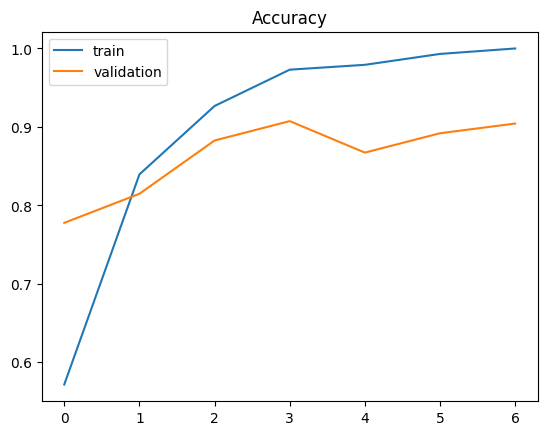

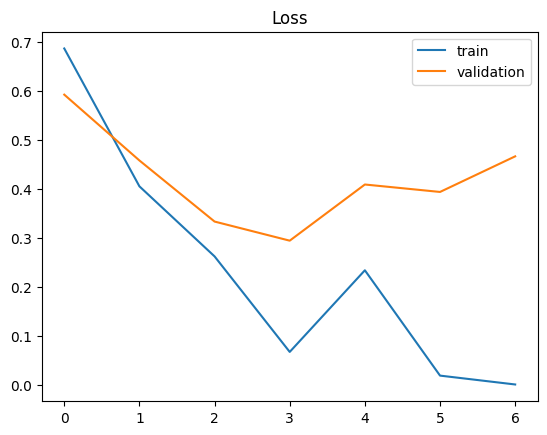

Testing model : /n
17/17 [==============================] - 0s 13ms/step - loss: 3.2006 - accuracy: 0.4796
Test set
  Loss: 3.201
  Accuracy: 0.480
22/22 [==============================] - 1s 11ms/step


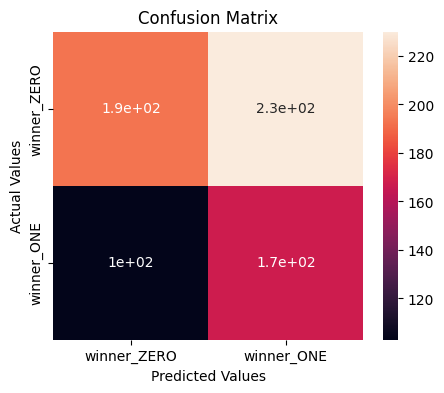

classification_report
               precision    recall  f1-score   support

           0       0.65      0.46      0.54       423
           1       0.42      0.62      0.50       270

    accuracy                           0.52       693
   macro avg       0.54      0.54      0.52       693
weighted avg       0.56      0.52      0.52       693

Epoch 1/7
41/41 [==============================] - 4s 50ms/step - loss: 0.6801 - accuracy: 0.5880 - val_loss: 0.5747 - val_accuracy: 0.7840
Epoch 2/7
41/41 [==============================] - 1s 32ms/step - loss: 0.4509 - accuracy: 0.8326 - val_loss: 0.3451 - val_accuracy: 0.8395
Epoch 3/7
41/41 [==============================] - 2s 39ms/step - loss: 0.1283 - accuracy: 0.9568 - val_loss: 0.4070 - val_accuracy: 0.8025
Epoch 4/7
41/41 [==============================] - 2s 39ms/step - loss: 0.1165 - accuracy: 0.9769 - val_loss: 0.1506 - val_accuracy: 0.9414
Epoch 5/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0092 - accuracy:

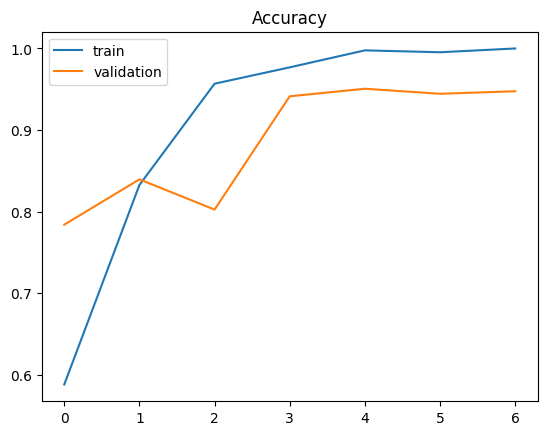

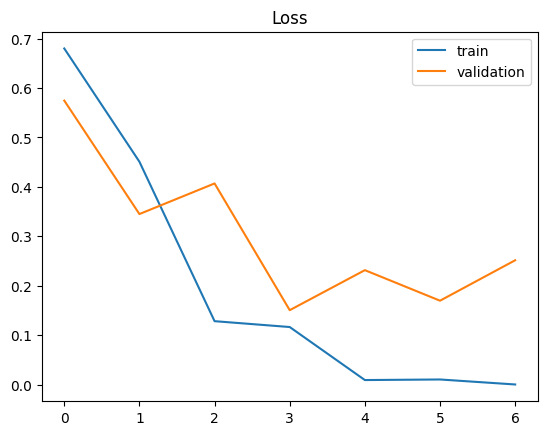

Testing model : /n
17/17 [==============================] - 0s 21ms/step - loss: 3.2015 - accuracy: 0.5407
Test set
  Loss: 3.201
  Accuracy: 0.541
22/22 [==============================] - 1s 11ms/step


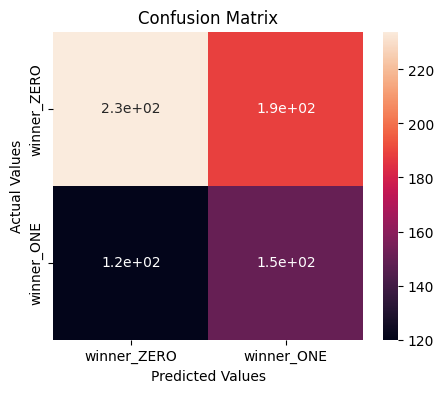

classification_report
               precision    recall  f1-score   support

           0       0.66      0.55      0.60       423
           1       0.44      0.56      0.49       270

    accuracy                           0.55       693
   macro avg       0.55      0.55      0.55       693
weighted avg       0.58      0.55      0.56       693

Epoch 1/7
41/41 [==============================] - 4s 48ms/step - loss: 0.6827 - accuracy: 0.5980 - val_loss: 0.5840 - val_accuracy: 0.7654
Epoch 2/7
41/41 [==============================] - 1s 33ms/step - loss: 0.3954 - accuracy: 0.8573 - val_loss: 0.3366 - val_accuracy: 0.8549
Epoch 3/7
41/41 [==============================] - 2s 43ms/step - loss: 0.1103 - accuracy: 0.9645 - val_loss: 0.2867 - val_accuracy: 0.8735
Epoch 4/7
41/41 [==============================] - 1s 35ms/step - loss: 0.0737 - accuracy: 0.9792 - val_loss: 0.1642 - val_accuracy: 0.9475
Epoch 5/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0247 - accuracy:

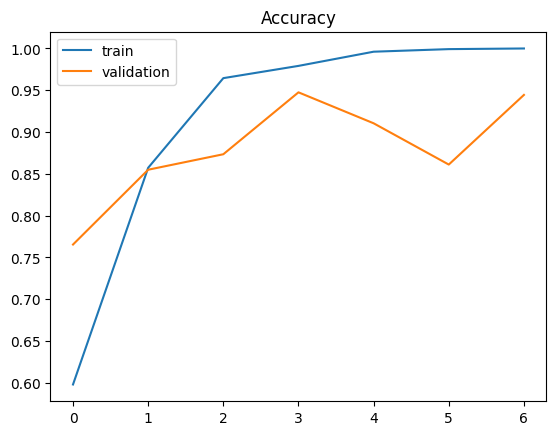

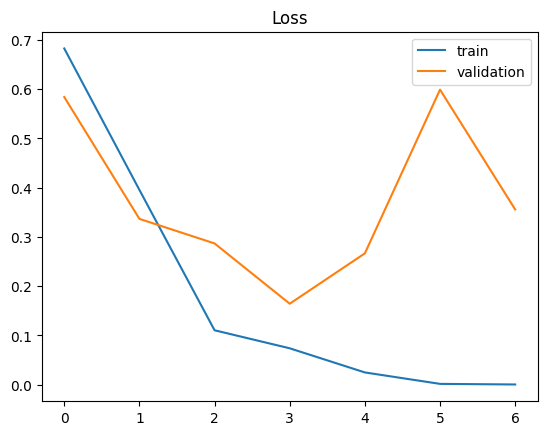

Testing model : /n
17/17 [==============================] - 0s 23ms/step - loss: 3.9939 - accuracy: 0.4667
Test set
  Loss: 3.994
  Accuracy: 0.467
22/22 [==============================] - 1s 13ms/step


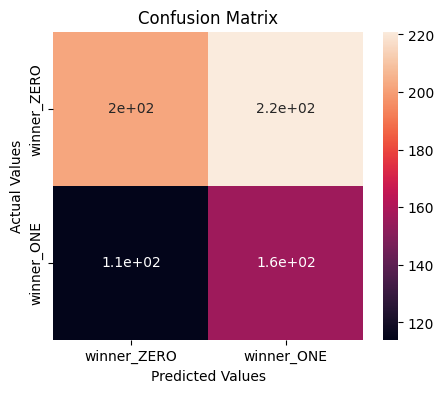

classification_report
               precision    recall  f1-score   support

           0       0.64      0.48      0.55       423
           1       0.41      0.58      0.48       270

    accuracy                           0.52       693
   macro avg       0.53      0.53      0.51       693
weighted avg       0.55      0.52      0.52       693

Epoch 1/7
41/41 [==============================] - 5s 50ms/step - loss: 0.6780 - accuracy: 0.5864 - val_loss: 0.6205 - val_accuracy: 0.6667
Epoch 2/7
41/41 [==============================] - 2s 45ms/step - loss: 0.3657 - accuracy: 0.8642 - val_loss: 0.3882 - val_accuracy: 0.8179
Epoch 3/7
41/41 [==============================] - 1s 34ms/step - loss: 0.1434 - accuracy: 0.9498 - val_loss: 0.3679 - val_accuracy: 0.8364
Epoch 4/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0445 - accuracy: 0.9884 - val_loss: 0.2958 - val_accuracy: 0.9198
Epoch 5/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0133 - accuracy:

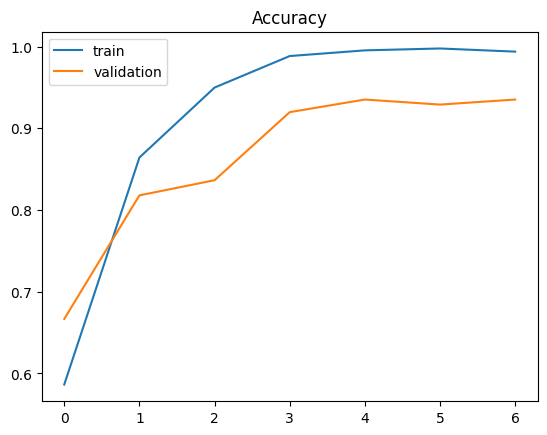

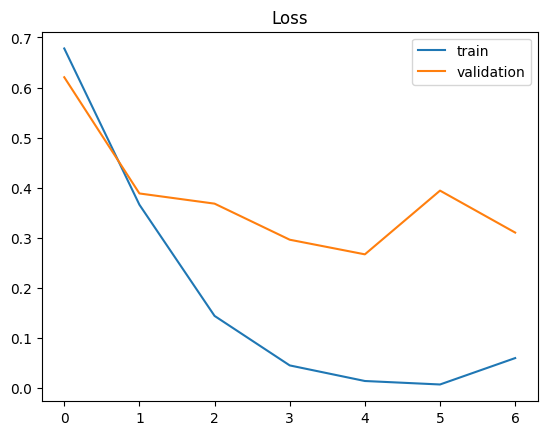

Testing model : /n
17/17 [==============================] - 0s 22ms/step - loss: 2.1569 - accuracy: 0.5685
Test set
  Loss: 2.157
  Accuracy: 0.569
22/22 [==============================] - 1s 12ms/step


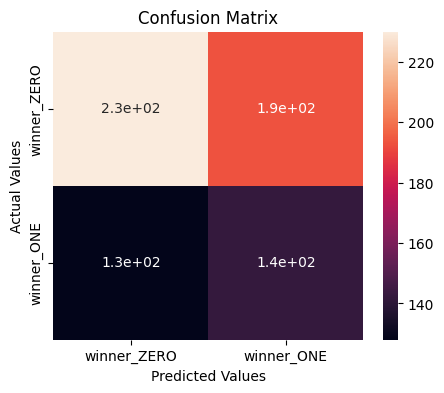

classification_report
               precision    recall  f1-score   support

           0       0.64      0.54      0.59       423
           1       0.42      0.53      0.47       270

    accuracy                           0.54       693
   macro avg       0.53      0.53      0.53       693
weighted avg       0.56      0.54      0.54       693

Acuuracy results of the 4 models :  [0.5194805194805194, 0.5541125541125541, 0.5165945165945166, 0.5367965367965368]
Avrage accuracy of this probability = 0.5317460317460317


In [60]:
# No preprocessing- Balancing -  Anonymisation (4)

dff=df
dff_pred = df_pred

dff = balancing_func(dff)

for i in range (len(dff)):
    dff['Facts'].iloc[i] = anonymisation(dff['Facts'].iloc[i] , dff['first_party'].iloc[i] , dff['second_party'].iloc[i])

for i in range (len(dff_pred)):
    dff_pred['Facts'].iloc[i] = anonymisation(dff_pred['Facts'].iloc[i], dff_pred['first_party'].iloc[i] , dff_pred['second_party'].iloc[i])

#-----------------------------------

train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4 = K_fold(dff)

#----------------------------------
x_1 , y_1 = padding_df(train_1)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1,y_1, test_size = 0.2, random_state = 42)

x_test_1 , y_test_1 = padding_df(test_1)

x_2 , y_2 = padding_df(train_2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2,y_2, test_size = 0.2, random_state = 42)

x_test_2 , y_test_2 = padding_df(test_2)

x_3 , y_3 = padding_df(train_3)
x_train_3 , x_val_3, y_train_3, y_val_3 = train_test_split(x_3,y_3, test_size = 0.2, random_state = 42)

x_test_3 , y_test_3 = padding_df(test_3)

x_4 , y_4 = padding_df(train_4)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_4,y_4, test_size = 0.2, random_state = 42)

x_test_4 , y_test_4 = padding_df(test_4)

#------------------------------------
x_prediction , target_labels = padding_df(dff_pred)

acc_result = []

for i in range (4):
    
    if i == 0 :
        the_model_4_1 = creating_model( x_train_1 , y_train_1 , x_val_1 , y_val_1, x_test_1 , y_test_1)
        
        y_predict = the_model_4_1.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 1 :
        the_model_4_2 = creating_model( x_train_2 , y_train_2 , x_val_2 , y_val_2, x_test_2 , y_test_2)
        
        y_predict = the_model_4_2.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 2 :
        the_model_4_3 = creating_model( x_train_3 , y_train_3 , x_val_3 , y_val_3, x_test_3 , y_test_3)
        
        y_predict = the_model_4_3.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 3 :
        the_model_4_4 = creating_model( x_train_4 , y_train_4 , x_val_4 , y_val_4, x_test_4 , y_test_4)
        
        y_predict = the_model_4_4.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
print('Acuuracy results of the 4 models : ',acc_result)
print('Avrage accuracy of this probability =' , sum(acc_result)/len(acc_result))

probabilities.append(sum(acc_result)/len(acc_result))


Epoch 1/7
52/52 [==============================] - 4s 45ms/step - loss: 0.6229 - accuracy: 0.6625 - val_loss: 0.4421 - val_accuracy: 0.8245
Epoch 2/7
52/52 [==============================] - 2s 31ms/step - loss: 0.1843 - accuracy: 0.9380 - val_loss: 0.1917 - val_accuracy: 0.9255
Epoch 3/7
52/52 [==============================] - 2s 34ms/step - loss: 0.2112 - accuracy: 0.9741 - val_loss: 0.3349 - val_accuracy: 0.9159
Epoch 4/7
52/52 [==============================] - 2s 39ms/step - loss: 0.0215 - accuracy: 0.9958 - val_loss: 0.4240 - val_accuracy: 0.8630
Epoch 5/7
52/52 [==============================] - 2s 31ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 0.2090 - val_accuracy: 0.9279
Epoch 6/7
52/52 [==============================] - 2s 34ms/step - loss: 0.0164 - accuracy: 0.9982 - val_loss: 0.1965 - val_accuracy: 0.9760
Epoch 7/7
52/52 [==============================] - 2s 31ms/step - loss: 1.4095e-04 - accuracy: 1.0000 - val_loss: 0.2588 - val_accuracy: 0.9423


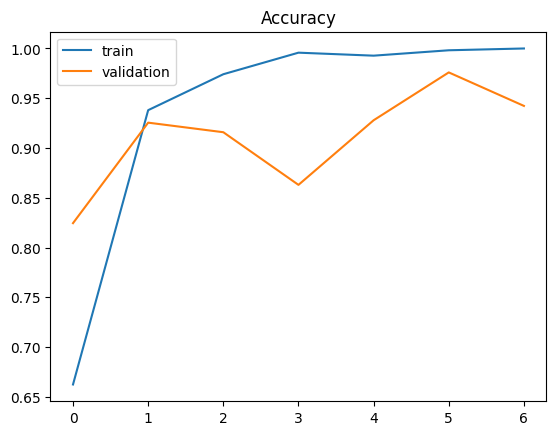

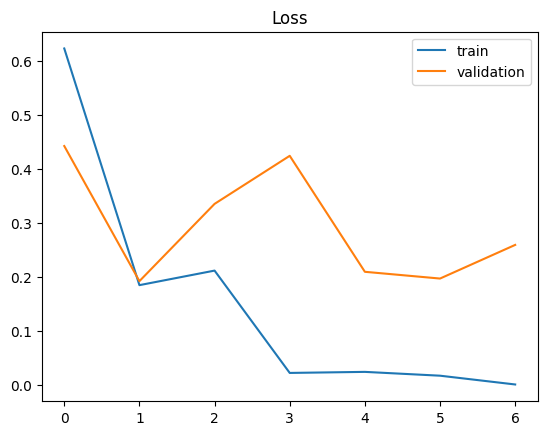

Testing model : /n
22/22 [==============================] - 1s 13ms/step - loss: 2.7567 - accuracy: 0.5988
Test set
  Loss: 2.757
  Accuracy: 0.599
22/22 [==============================] - 1s 11ms/step


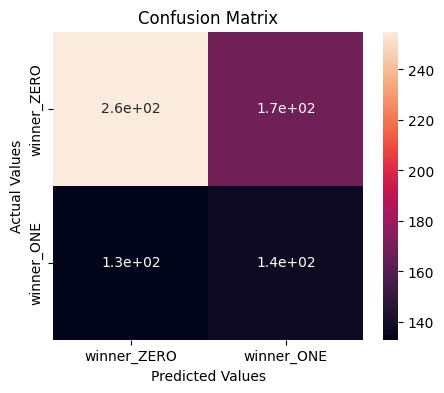

classification_report
               precision    recall  f1-score   support

           0       0.66      0.60      0.63       423
           1       0.45      0.51      0.48       270

    accuracy                           0.57       693
   macro avg       0.55      0.56      0.55       693
weighted avg       0.58      0.57      0.57       693

Epoch 1/7
52/52 [==============================] - 5s 57ms/step - loss: 0.6368 - accuracy: 0.6516 - val_loss: 0.5040 - val_accuracy: 0.7740
Epoch 2/7
52/52 [==============================] - 2s 32ms/step - loss: 0.2200 - accuracy: 0.9242 - val_loss: 0.2801 - val_accuracy: 0.8894
Epoch 3/7
52/52 [==============================] - 2s 33ms/step - loss: 0.0625 - accuracy: 0.9838 - val_loss: 0.2529 - val_accuracy: 0.9135
Epoch 4/7
52/52 [==============================] - 2s 35ms/step - loss: 0.2109 - accuracy: 0.9862 - val_loss: 0.3089 - val_accuracy: 0.9279
Epoch 5/7
52/52 [==============================] - 2s 35ms/step - loss: 0.1390 - accuracy:

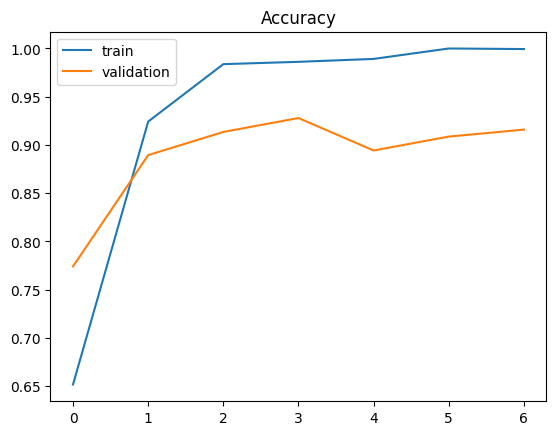

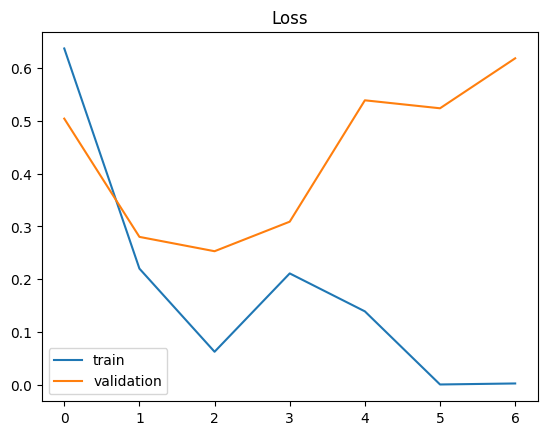

Testing model : /n
22/22 [==============================] - 1s 21ms/step - loss: 3.5369 - accuracy: 0.5440
Test set
  Loss: 3.537
  Accuracy: 0.544
22/22 [==============================] - 1s 12ms/step


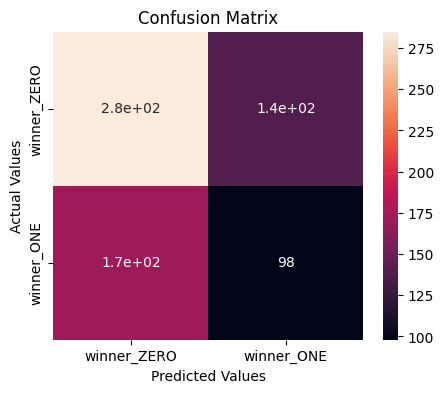

classification_report
               precision    recall  f1-score   support

           0       0.62      0.67      0.65       423
           1       0.42      0.36      0.39       270

    accuracy                           0.55       693
   macro avg       0.52      0.52      0.52       693
weighted avg       0.54      0.55      0.55       693

Epoch 1/7
52/52 [==============================] - 5s 52ms/step - loss: 0.6130 - accuracy: 0.6703 - val_loss: 0.3776 - val_accuracy: 0.8365
Epoch 2/7
52/52 [==============================] - 2s 33ms/step - loss: 0.1891 - accuracy: 0.9326 - val_loss: 0.1893 - val_accuracy: 0.9255
Epoch 3/7
52/52 [==============================] - 2s 33ms/step - loss: 0.0694 - accuracy: 0.9813 - val_loss: 0.4039 - val_accuracy: 0.9087
Epoch 4/7
52/52 [==============================] - 2s 33ms/step - loss: 0.0632 - accuracy: 0.9910 - val_loss: 0.1862 - val_accuracy: 0.9543
Epoch 5/7
52/52 [==============================] - 2s 33ms/step - loss: 0.0069 - accuracy:

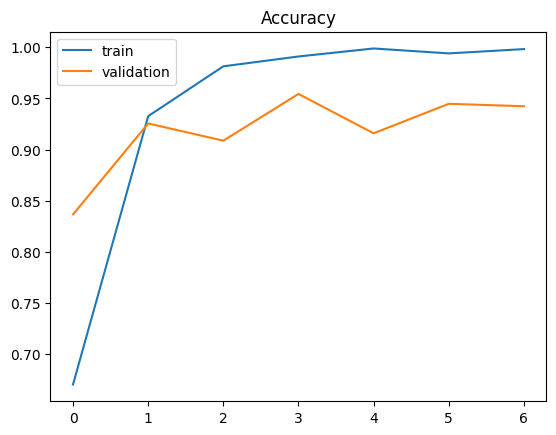

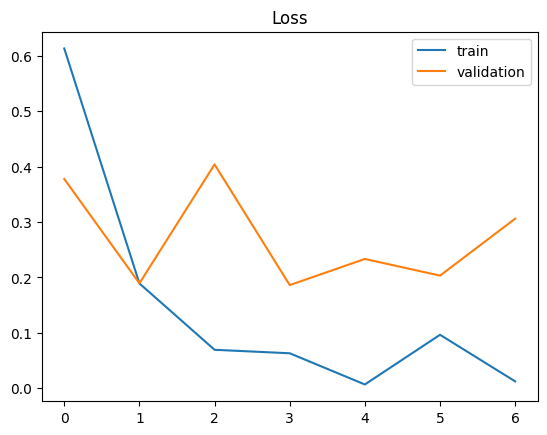

Testing model : /n
22/22 [==============================] - 1s 15ms/step - loss: 2.9262 - accuracy: 0.5296
Test set
  Loss: 2.926
  Accuracy: 0.530
22/22 [==============================] - 1s 12ms/step


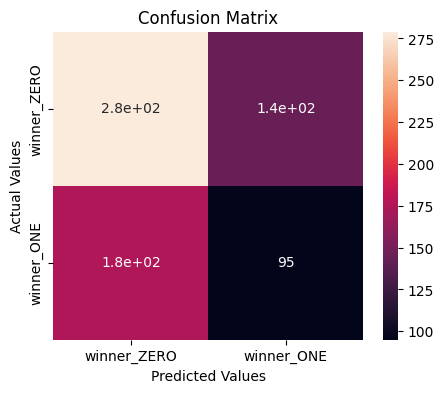

classification_report
               precision    recall  f1-score   support

           0       0.61      0.66      0.64       423
           1       0.40      0.35      0.37       270

    accuracy                           0.54       693
   macro avg       0.51      0.51      0.50       693
weighted avg       0.53      0.54      0.53       693

Epoch 1/7
52/52 [==============================] - 4s 48ms/step - loss: 0.6447 - accuracy: 0.6609 - val_loss: 0.3981 - val_accuracy: 0.8678
Epoch 2/7
52/52 [==============================] - 2s 34ms/step - loss: 0.2116 - accuracy: 0.9260 - val_loss: 0.2824 - val_accuracy: 0.9038
Epoch 3/7
52/52 [==============================] - 2s 37ms/step - loss: 0.0554 - accuracy: 0.9832 - val_loss: 0.4111 - val_accuracy: 0.9038
Epoch 4/7
52/52 [==============================] - 2s 42ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.3602 - val_accuracy: 0.9375
Epoch 5/7
52/52 [==============================] - 2s 34ms/step - loss: 0.0037 - accuracy:

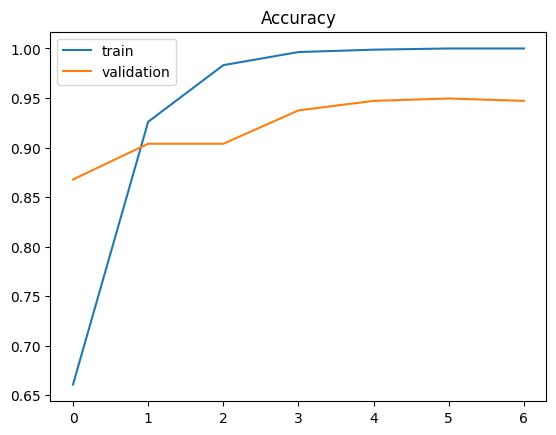

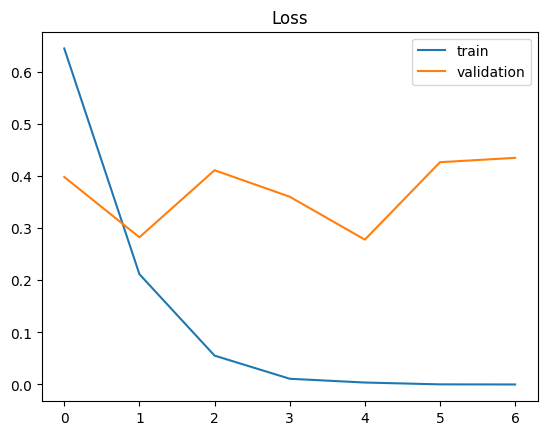

Testing model : /n
22/22 [==============================] - 1s 22ms/step - loss: 4.8053 - accuracy: 0.5289
Test set
  Loss: 4.805
  Accuracy: 0.529
22/22 [==============================] - 1s 13ms/step


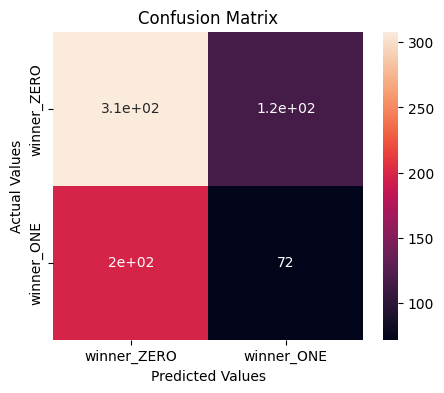

classification_report
               precision    recall  f1-score   support

           0       0.61      0.73      0.66       423
           1       0.39      0.27      0.32       270

    accuracy                           0.55       693
   macro avg       0.50      0.50      0.49       693
weighted avg       0.52      0.55      0.53       693

Acuuracy results of the 4 models :  [0.5656565656565656, 0.5526695526695526, 0.5396825396825397, 0.5483405483405484]
Avrage accuracy of this probability = 0.5515873015873016


In [61]:
#  preprocessing- No Balancing -  No Anonymisation (5)

dff = df
dff_pred = df_pred

dff = preprocessing (dff)
dff_pred = preprocessing (dff_pred)

#-----------------------------------

train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4 = K_fold(dff)

#----------------------------------

x_1 , y_1 = padding_df(train_1)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1,y_1, test_size = 0.2, random_state = 42)

x_test_1 , y_test_1 = padding_df(test_1)

x_2 , y_2 = padding_df(train_2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2,y_2, test_size = 0.2, random_state = 42)

x_test_2 , y_test_2 = padding_df(test_2)

x_3 , y_3 = padding_df(train_3)
x_train_3 , x_val_3, y_train_3, y_val_3 = train_test_split(x_3,y_3, test_size = 0.2, random_state = 42)

x_test_3 , y_test_3 = padding_df(test_3)

x_4 , y_4 = padding_df(train_4)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_4,y_4, test_size = 0.2, random_state = 42)

x_test_4 , y_test_4 = padding_df(test_4)

#------------------------------------
x_prediction , target_labels = padding_df(dff_pred)

acc_result = []

for i in range (4):
    
    if i == 0 :
        the_model_5_1 = creating_model( x_train_1 , y_train_1 , x_val_1 , y_val_1, x_test_1 , y_test_1)
        
        y_predict = the_model_5_1.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 1 :
        the_model_5_2 = creating_model( x_train_2 , y_train_2 , x_val_2 , y_val_2, x_test_2 , y_test_2)
        
        y_predict = the_model_5_2.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 2 :
        the_model_5_3 = creating_model( x_train_3 , y_train_3 , x_val_3 , y_val_3, x_test_3 , y_test_3)
        
        y_predict = the_model_5_3.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 3 :
        the_model_5_4 = creating_model( x_train_4 , y_train_4 , x_val_4 , y_val_4, x_test_4 , y_test_4)
        
        y_predict = the_model_5_4.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
print('Acuuracy results of the 4 models : ',acc_result)
print('Avrage accuracy of this probability =' , sum(acc_result)/len(acc_result))

probabilities.append(sum(acc_result)/len(acc_result))


Epoch 1/7
52/52 [==============================] - 6s 52ms/step - loss: 0.6270 - accuracy: 0.6721 - val_loss: 0.3749 - val_accuracy: 0.8389
Epoch 2/7
52/52 [==============================] - 2s 33ms/step - loss: 0.2128 - accuracy: 0.9266 - val_loss: 0.1929 - val_accuracy: 0.9279
Epoch 3/7
52/52 [==============================] - 2s 35ms/step - loss: 0.0763 - accuracy: 0.9765 - val_loss: 0.1632 - val_accuracy: 0.9519
Epoch 4/7
52/52 [==============================] - 2s 34ms/step - loss: 0.0200 - accuracy: 0.9910 - val_loss: 0.1936 - val_accuracy: 0.9471
Epoch 5/7
52/52 [==============================] - 2s 31ms/step - loss: 0.0047 - accuracy: 0.9982 - val_loss: 0.2307 - val_accuracy: 0.9399
Epoch 6/7
52/52 [==============================] - 2s 31ms/step - loss: 0.0046 - accuracy: 0.9982 - val_loss: 0.2428 - val_accuracy: 0.9615
Epoch 7/7
52/52 [==============================] - 2s 35ms/step - loss: 2.4720e-05 - accuracy: 1.0000 - val_loss: 0.3096 - val_accuracy: 0.9519


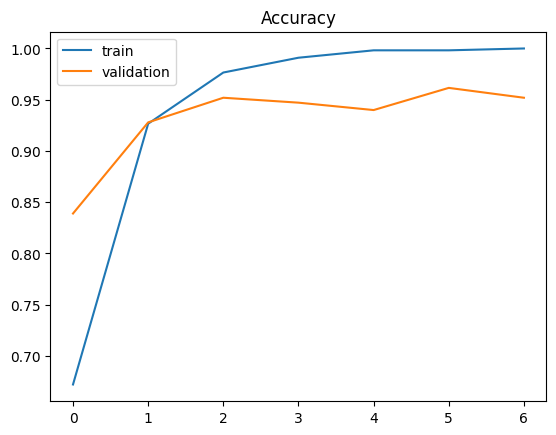

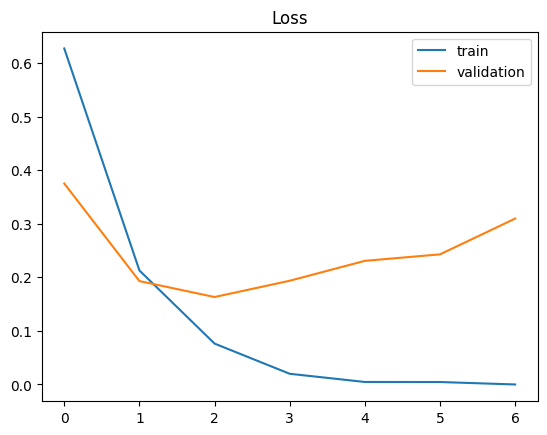

Testing model : /n
22/22 [==============================] - 1s 21ms/step - loss: 3.1378 - accuracy: 0.5988
Test set
  Loss: 3.138
  Accuracy: 0.599
22/22 [==============================] - 1s 11ms/step


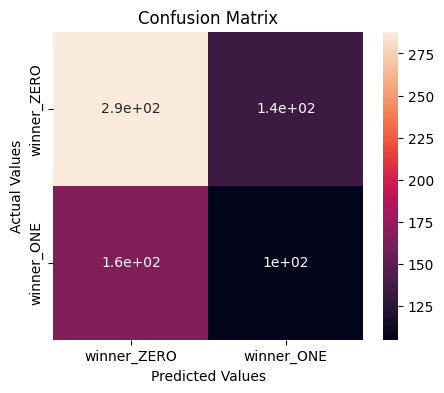

classification_report
               precision    recall  f1-score   support

           0       0.64      0.68      0.66       423
           1       0.44      0.39      0.41       270

    accuracy                           0.57       693
   macro avg       0.54      0.53      0.53       693
weighted avg       0.56      0.57      0.56       693

Epoch 1/7
52/52 [==============================] - 5s 53ms/step - loss: 0.6489 - accuracy: 0.6582 - val_loss: 0.5248 - val_accuracy: 0.8389
Epoch 2/7
52/52 [==============================] - 2s 31ms/step - loss: 0.2416 - accuracy: 0.9218 - val_loss: 0.3094 - val_accuracy: 0.8918
Epoch 3/7
52/52 [==============================] - 2s 31ms/step - loss: 0.1447 - accuracy: 0.9735 - val_loss: 0.2990 - val_accuracy: 0.9375
Epoch 4/7
52/52 [==============================] - 2s 32ms/step - loss: 0.0145 - accuracy: 0.9970 - val_loss: 0.3277 - val_accuracy: 0.9399
Epoch 5/7
52/52 [==============================] - 2s 32ms/step - loss: 0.1329 - accuracy:

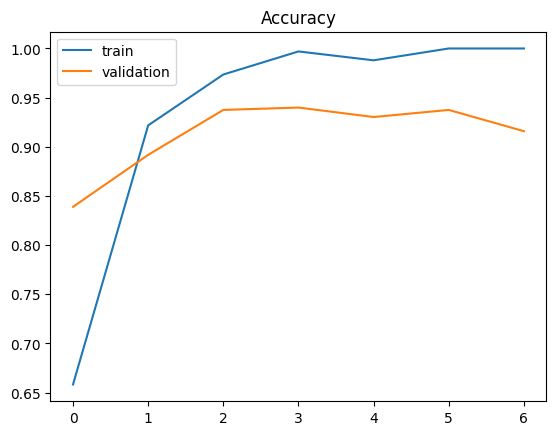

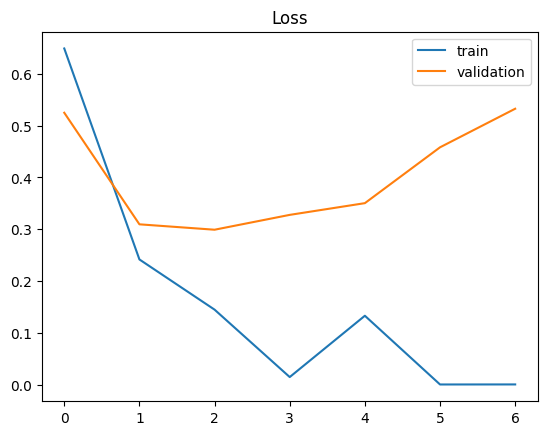

Testing model : /n
22/22 [==============================] - 1s 21ms/step - loss: 2.8971 - accuracy: 0.5440
Test set
  Loss: 2.897
  Accuracy: 0.544
22/22 [==============================] - 1s 11ms/step


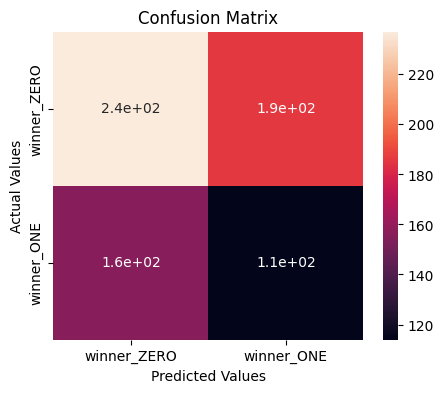

classification_report
               precision    recall  f1-score   support

           0       0.60      0.56      0.58       423
           1       0.38      0.42      0.40       270

    accuracy                           0.51       693
   macro avg       0.49      0.49      0.49       693
weighted avg       0.52      0.51      0.51       693

Epoch 1/7
52/52 [==============================] - 5s 47ms/step - loss: 0.6240 - accuracy: 0.6703 - val_loss: 0.5314 - val_accuracy: 0.7380
Epoch 2/7
52/52 [==============================] - 2s 32ms/step - loss: 0.2110 - accuracy: 0.9284 - val_loss: 0.1709 - val_accuracy: 0.9375
Epoch 3/7
52/52 [==============================] - 2s 32ms/step - loss: 0.1825 - accuracy: 0.9681 - val_loss: 0.1388 - val_accuracy: 0.9567
Epoch 4/7
52/52 [==============================] - 2s 32ms/step - loss: 0.0123 - accuracy: 0.9952 - val_loss: 0.1891 - val_accuracy: 0.9519
Epoch 5/7
52/52 [==============================] - 2s 32ms/step - loss: 0.0042 - accuracy:

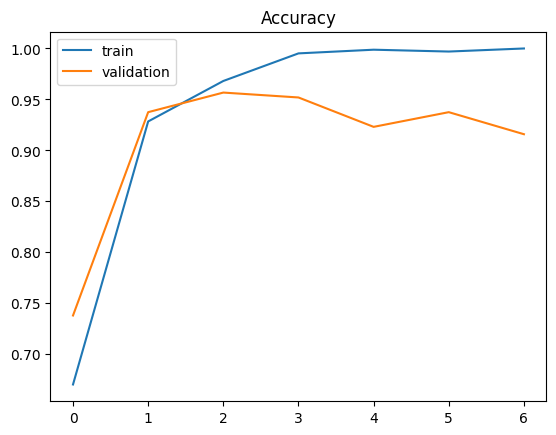

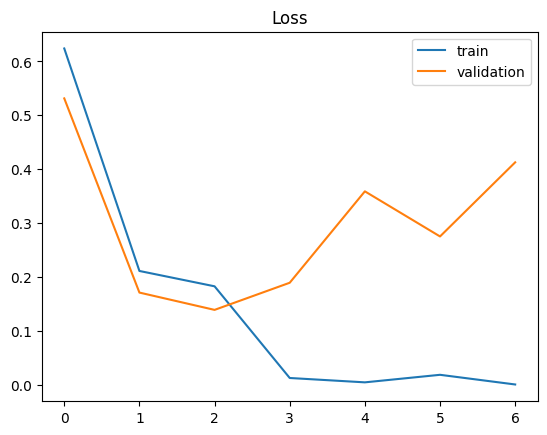

Testing model : /n
22/22 [==============================] - 1s 21ms/step - loss: 3.1563 - accuracy: 0.5354
Test set
  Loss: 3.156
  Accuracy: 0.535
22/22 [==============================] - 1s 12ms/step


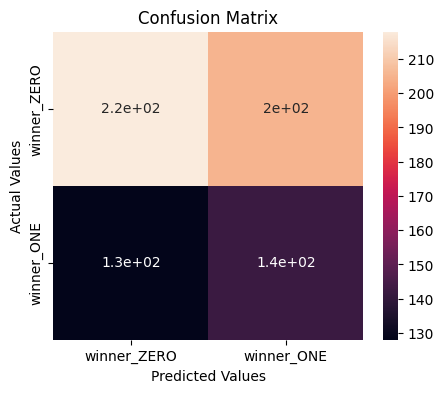

classification_report
               precision    recall  f1-score   support

           0       0.63      0.52      0.57       423
           1       0.41      0.53      0.46       270

    accuracy                           0.52       693
   macro avg       0.52      0.52      0.51       693
weighted avg       0.54      0.52      0.53       693

Epoch 1/7
52/52 [==============================] - 5s 45ms/step - loss: 0.6167 - accuracy: 0.6669 - val_loss: 0.3606 - val_accuracy: 0.8942
Epoch 2/7
52/52 [==============================] - 2s 34ms/step - loss: 0.2040 - accuracy: 0.9266 - val_loss: 0.1918 - val_accuracy: 0.9447
Epoch 3/7
52/52 [==============================] - 2s 34ms/step - loss: 0.0460 - accuracy: 0.9892 - val_loss: 0.1926 - val_accuracy: 0.9543
Epoch 4/7
52/52 [==============================] - 2s 33ms/step - loss: 0.0328 - accuracy: 0.9946 - val_loss: 0.2148 - val_accuracy: 0.9519
Epoch 5/7
52/52 [==============================] - 2s 33ms/step - loss: 0.0056 - accuracy:

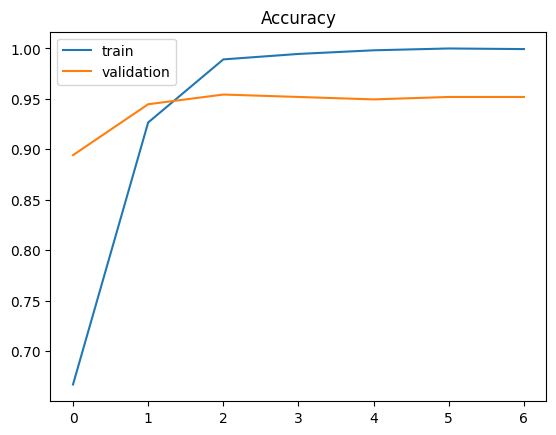

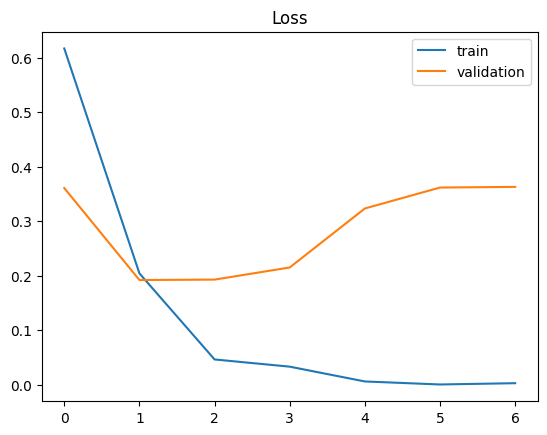

Testing model : /n
22/22 [==============================] - 1s 22ms/step - loss: 3.6420 - accuracy: 0.5520
Test set
  Loss: 3.642
  Accuracy: 0.552
22/22 [==============================] - 1s 16ms/step


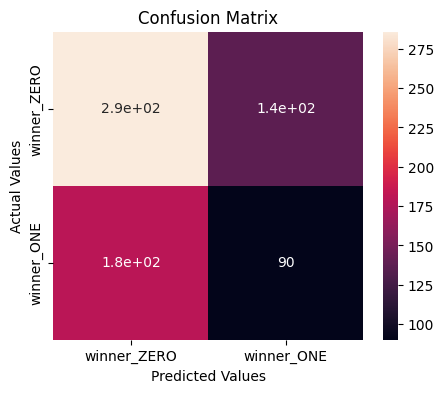

classification_report
               precision    recall  f1-score   support

           0       0.61      0.68      0.64       423
           1       0.40      0.33      0.36       270

    accuracy                           0.54       693
   macro avg       0.51      0.50      0.50       693
weighted avg       0.53      0.54      0.53       693

Acuuracy results of the 4 models :  [0.5670995670995671, 0.5064935064935064, 0.5194805194805194, 0.5425685425685426]
Avrage accuracy of this probability = 0.5339105339105339


In [62]:
#  preprocessing- No Balancing -   Anonymisation (6)

dff=df
dff_pred = df_pred

for i in range (len(dff)):
    dff['Facts'].iloc[i] = anonymisation(dff['Facts'].iloc[i] , dff['first_party'].iloc[i] , dff['second_party'].iloc[i])

for i in range (len(dff_pred)):
    dff_pred['Facts'].iloc[i] = anonymisation(dff_pred['Facts'].iloc[i], dff_pred['first_party'].iloc[i] , dff_pred['second_party'].iloc[i])

dff = preprocessing(dff)
dff_pred = preprocessing(dff_pred)

#-----------------------------------

train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4 = K_fold(dff)

#----------------------------------

x_1 , y_1 = padding_df(train_1)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1,y_1, test_size = 0.2, random_state = 42)

x_test_1 , y_test_1 = padding_df(test_1)

x_2 , y_2 = padding_df(train_2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2,y_2, test_size = 0.2, random_state = 42)

x_test_2 , y_test_2 = padding_df(test_2)

x_3 , y_3 = padding_df(train_3)
x_train_3 , x_val_3, y_train_3, y_val_3 = train_test_split(x_3,y_3, test_size = 0.2, random_state = 42)

x_test_3 , y_test_3 = padding_df(test_3)

x_4 , y_4 = padding_df(train_4)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_4,y_4, test_size = 0.2, random_state = 42)

x_test_4 , y_test_4 = padding_df(test_4)

#------------------------------------
x_prediction , target_labels = padding_df(dff_pred)

acc_result = []

for i in range (4):
    
    if i == 0 :
        the_model_6_1 = creating_model( x_train_1 , y_train_1 , x_val_1 , y_val_1, x_test_1 , y_test_1)
        
        y_predict = the_model_6_1.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 1 :
        the_model_6_2 = creating_model( x_train_2 , y_train_2 , x_val_2 , y_val_2, x_test_2 , y_test_2)
        
        y_predict = the_model_6_2.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 2 :
        the_model_6_3 = creating_model( x_train_3 , y_train_3 , x_val_3 , y_val_3, x_test_3 , y_test_3)
        
        y_predict = the_model_6_3.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 3 :
        the_model_6_4 = creating_model( x_train_4 , y_train_4 , x_val_4 , y_val_4, x_test_4 , y_test_4)
        
        y_predict = the_model_6_4.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
print('Acuuracy results of the 4 models : ',acc_result)
print('Avrage accuracy of this probability =' , sum(acc_result)/len(acc_result))

probabilities.append(sum(acc_result)/len(acc_result))


Epoch 1/7
41/41 [==============================] - 4s 57ms/step - loss: 0.6756 - accuracy: 0.6420 - val_loss: 0.5100 - val_accuracy: 0.8056
Epoch 2/7
41/41 [==============================] - 1s 32ms/step - loss: 0.2809 - accuracy: 0.8997 - val_loss: 0.3326 - val_accuracy: 0.8549
Epoch 3/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0843 - accuracy: 0.9761 - val_loss: 0.2951 - val_accuracy: 0.8796
Epoch 4/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0181 - accuracy: 0.9954 - val_loss: 0.3003 - val_accuracy: 0.9043
Epoch 5/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.4914 - val_accuracy: 0.8488
Epoch 6/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3977 - val_accuracy: 0.9228
Epoch 7/7
41/41 [==============================] - 1s 31ms/step - loss: 9.3318e-06 - accuracy: 1.0000 - val_loss: 0.3972 - val_accuracy: 0.9290


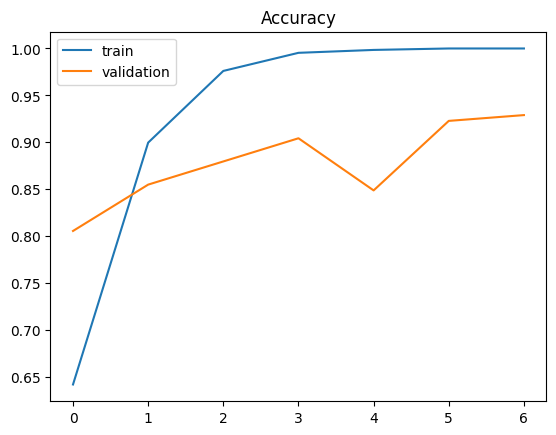

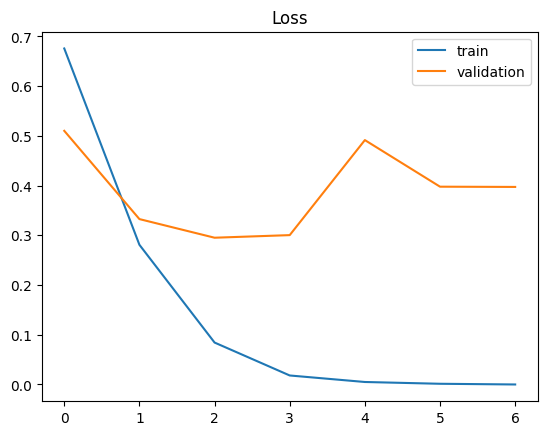

Testing model : /n
17/17 [==============================] - 0s 22ms/step - loss: 3.2449 - accuracy: 0.5444
Test set
  Loss: 3.245
  Accuracy: 0.544
22/22 [==============================] - 1s 20ms/step


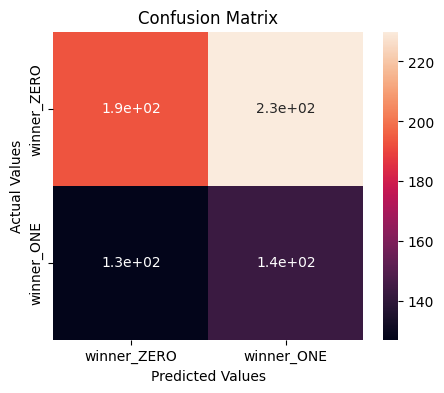

classification_report
               precision    recall  f1-score   support

           0       0.60      0.46      0.52       423
           1       0.38      0.53      0.44       270

    accuracy                           0.48       693
   macro avg       0.49      0.49      0.48       693
weighted avg       0.52      0.48      0.49       693

Epoch 1/7
41/41 [==============================] - 6s 62ms/step - loss: 0.6614 - accuracy: 0.6196 - val_loss: 0.5255 - val_accuracy: 0.7284
Epoch 2/7
41/41 [==============================] - 1s 33ms/step - loss: 0.2323 - accuracy: 0.9105 - val_loss: 0.2995 - val_accuracy: 0.8858
Epoch 3/7
41/41 [==============================] - 2s 39ms/step - loss: 0.0620 - accuracy: 0.9807 - val_loss: 0.2441 - val_accuracy: 0.9074
Epoch 4/7
41/41 [==============================] - 2s 46ms/step - loss: 0.0112 - accuracy: 0.9985 - val_loss: 0.2989 - val_accuracy: 0.9105
Epoch 5/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0165 - accuracy:

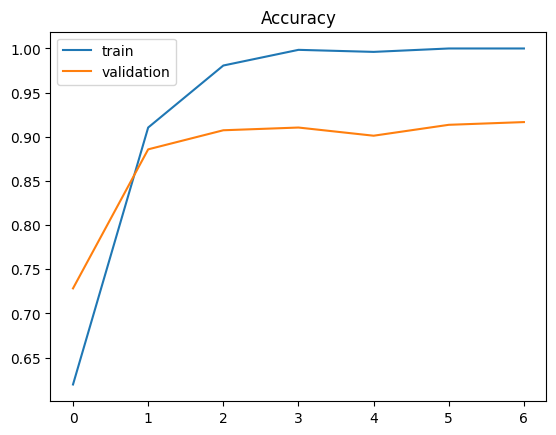

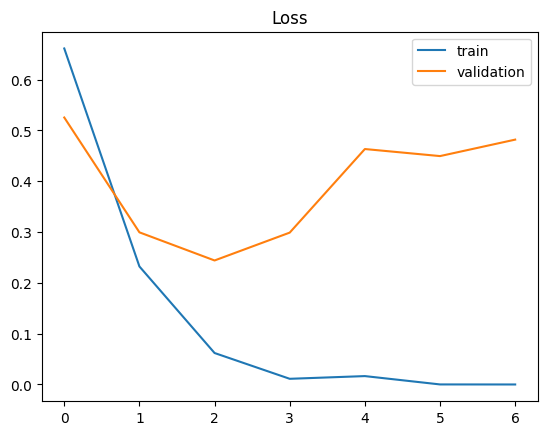

Testing model : /n
17/17 [==============================] - 0s 24ms/step - loss: 3.3407 - accuracy: 0.5185
Test set
  Loss: 3.341
  Accuracy: 0.519
22/22 [==============================] - 1s 16ms/step


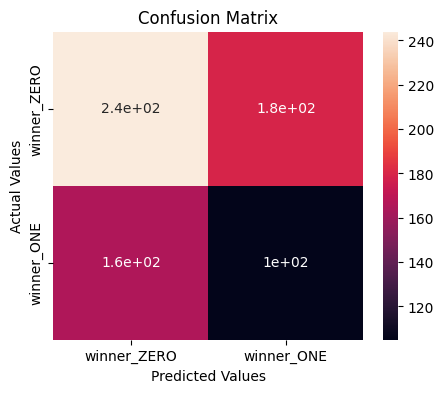

classification_report
               precision    recall  f1-score   support

           0       0.60      0.58      0.59       423
           1       0.37      0.39      0.38       270

    accuracy                           0.50       693
   macro avg       0.48      0.48      0.48       693
weighted avg       0.51      0.50      0.51       693

Epoch 1/7
41/41 [==============================] - 4s 51ms/step - loss: 0.6576 - accuracy: 0.6111 - val_loss: 0.5339 - val_accuracy: 0.7562
Epoch 2/7
41/41 [==============================] - 1s 33ms/step - loss: 0.3358 - accuracy: 0.8835 - val_loss: 0.3098 - val_accuracy: 0.8735
Epoch 3/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0561 - accuracy: 0.9838 - val_loss: 1.0362 - val_accuracy: 0.7377
Epoch 4/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0082 - accuracy: 0.9985 - val_loss: 0.5826 - val_accuracy: 0.9074
Epoch 5/7
41/41 [==============================] - 2s 38ms/step - loss: 0.0221 - accuracy:

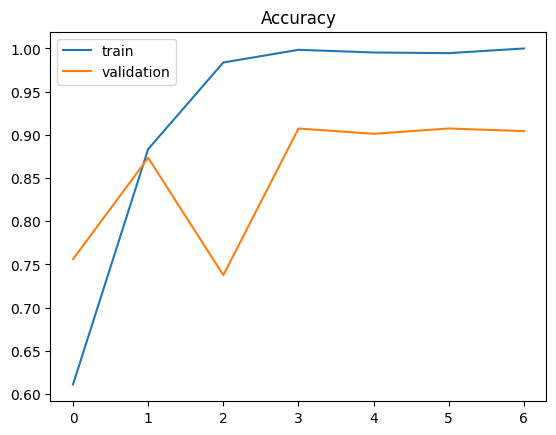

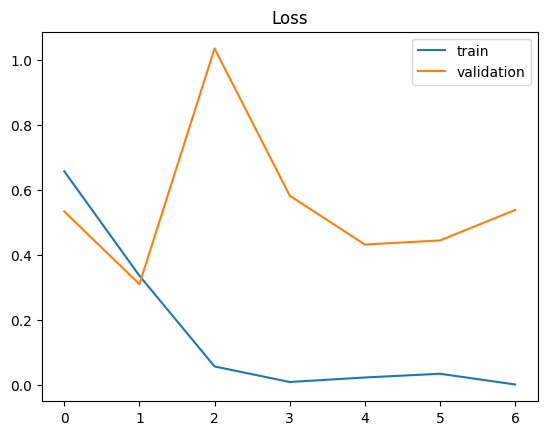

Testing model : /n
17/17 [==============================] - 0s 22ms/step - loss: 2.1763 - accuracy: 0.5500
Test set
  Loss: 2.176
  Accuracy: 0.550
22/22 [==============================] - 1s 12ms/step


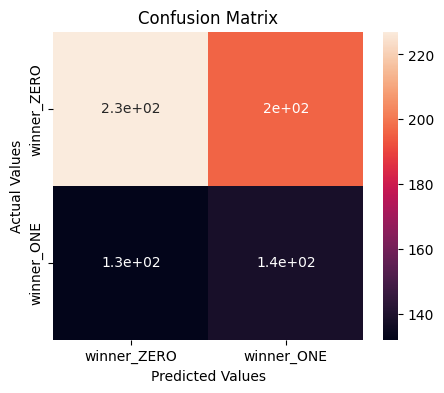

classification_report
               precision    recall  f1-score   support

           0       0.63      0.54      0.58       423
           1       0.41      0.51      0.46       270

    accuracy                           0.53       693
   macro avg       0.52      0.52      0.52       693
weighted avg       0.55      0.53      0.53       693

Epoch 1/7
41/41 [==============================] - 4s 51ms/step - loss: 0.6923 - accuracy: 0.6227 - val_loss: 0.5209 - val_accuracy: 0.7809
Epoch 2/7
41/41 [==============================] - 1s 33ms/step - loss: 0.2426 - accuracy: 0.9151 - val_loss: 0.3597 - val_accuracy: 0.8735
Epoch 3/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0789 - accuracy: 0.9738 - val_loss: 0.2836 - val_accuracy: 0.8704
Epoch 4/7
41/41 [==============================] - 1s 34ms/step - loss: 0.0284 - accuracy: 0.9946 - val_loss: 0.3008 - val_accuracy: 0.8765
Epoch 5/7
41/41 [==============================] - 2s 42ms/step - loss: 0.0062 - accuracy:

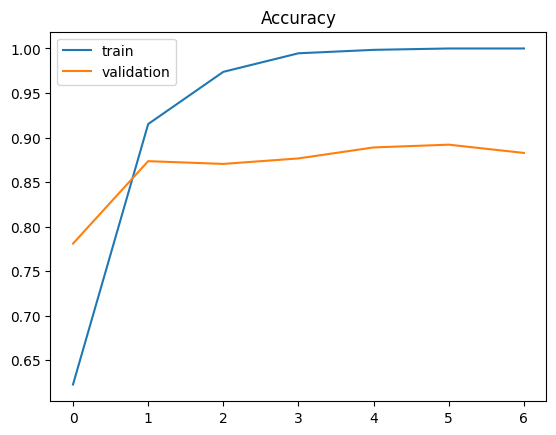

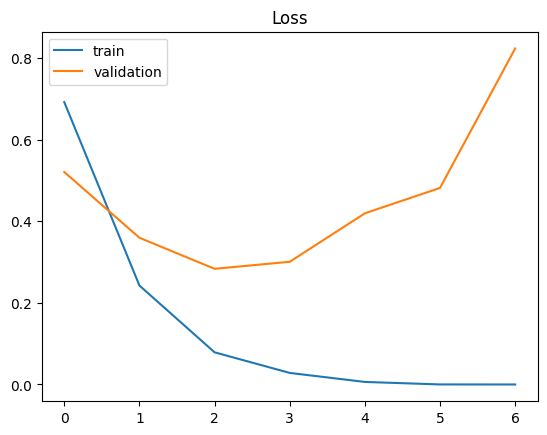

Testing model : /n
17/17 [==============================] - 0s 14ms/step - loss: 4.0320 - accuracy: 0.5852
Test set
  Loss: 4.032
  Accuracy: 0.585
22/22 [==============================] - 1s 12ms/step


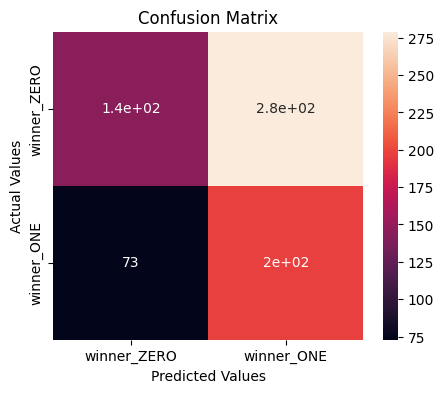

classification_report
               precision    recall  f1-score   support

           0       0.66      0.34      0.45       423
           1       0.41      0.73      0.53       270

    accuracy                           0.49       693
   macro avg       0.54      0.54      0.49       693
weighted avg       0.57      0.49      0.48       693

Acuuracy results of the 4 models :  [0.48484848484848486, 0.5036075036075036, 0.5266955266955267, 0.49206349206349204]
Avrage accuracy of this probability = 0.5018037518037518


In [63]:
#  preprocessing-  Balancing -   No Anonymisation (7)

dff=df
dff_pred=dff_pred

dff = balancing_func(dff)

dff = preprocessing(dff)
dff_pred = preprocessing(dff_pred)

#-----------------------------------

train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4 = K_fold(dff)

#----------------------------------

x_1 , y_1 = padding_df(train_1)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1,y_1, test_size = 0.2, random_state = 42)

x_test_1 , y_test_1 = padding_df(test_1)

x_2 , y_2 = padding_df(train_2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2,y_2, test_size = 0.2, random_state = 42)

x_test_2 , y_test_2 = padding_df(test_2)

x_3 , y_3 = padding_df(train_3)
x_train_3 , x_val_3, y_train_3, y_val_3 = train_test_split(x_3,y_3, test_size = 0.2, random_state = 42)

x_test_3 , y_test_3 = padding_df(test_3)

x_4 , y_4 = padding_df(train_4)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_4,y_4, test_size = 0.2, random_state = 42)

x_test_4 , y_test_4 = padding_df(test_4)

#------------------------------------
x_prediction , target_labels = padding_df(dff_pred)

acc_result = []

for i in range (4):
    
    if i == 0 :
        the_model_7_1 = creating_model( x_train_1 , y_train_1 , x_val_1 , y_val_1, x_test_1 , y_test_1)
        
        y_predict = the_model_7_1.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 1 :
        the_model_7_2 = creating_model( x_train_2 , y_train_2 , x_val_2 , y_val_2, x_test_2 , y_test_2)
        
        y_predict = the_model_7_2.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 2 :
        the_model_7_3 = creating_model( x_train_3 , y_train_3 , x_val_3 , y_val_3, x_test_3 , y_test_3)
        
        y_predict = the_model_7_3.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 3 :
        the_model_7_4 = creating_model( x_train_4 , y_train_4 , x_val_4 , y_val_4, x_test_4 , y_test_4)
        
        y_predict = the_model_7_4.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
print('Acuuracy results of the 4 models : ',acc_result)
print('Avrage accuracy of this probability =' , sum(acc_result)/len(acc_result))

probabilities.append(sum(acc_result)/len(acc_result))
  

Epoch 1/7
41/41 [==============================] - 4s 54ms/step - loss: 0.6641 - accuracy: 0.6042 - val_loss: 0.4497 - val_accuracy: 0.8395
Epoch 2/7
41/41 [==============================] - 2s 40ms/step - loss: 0.2765 - accuracy: 0.9043 - val_loss: 0.3151 - val_accuracy: 0.9074
Epoch 3/7
41/41 [==============================] - 1s 31ms/step - loss: 0.0865 - accuracy: 0.9784 - val_loss: 0.3202 - val_accuracy: 0.9074
Epoch 4/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 1.3594 - val_accuracy: 0.7623
Epoch 5/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0031 - accuracy: 0.9985 - val_loss: 0.4068 - val_accuracy: 0.9043
Epoch 6/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0110 - accuracy: 0.9985 - val_loss: 0.2206 - val_accuracy: 0.9414
Epoch 7/7
41/41 [==============================] - 1s 32ms/step - loss: 5.0722e-04 - accuracy: 1.0000 - val_loss: 0.5241 - val_accuracy: 0.8827


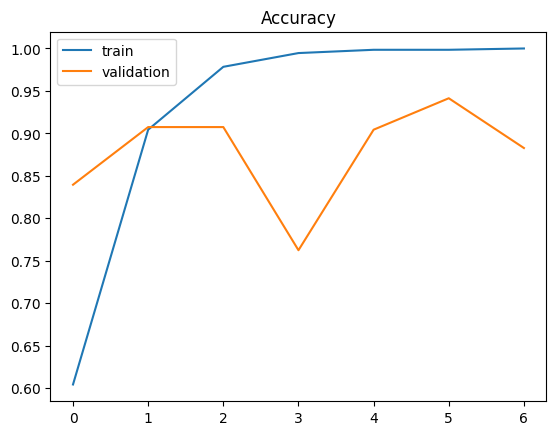

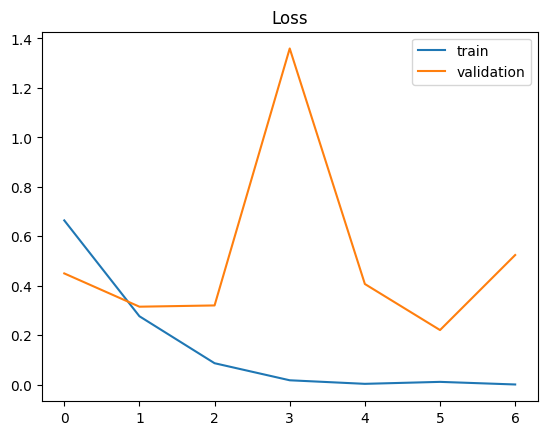

Testing model : /n
17/17 [==============================] - 0s 13ms/step - loss: 2.9466 - accuracy: 0.5259
Test set
  Loss: 2.947
  Accuracy: 0.526
22/22 [==============================] - 1s 11ms/step


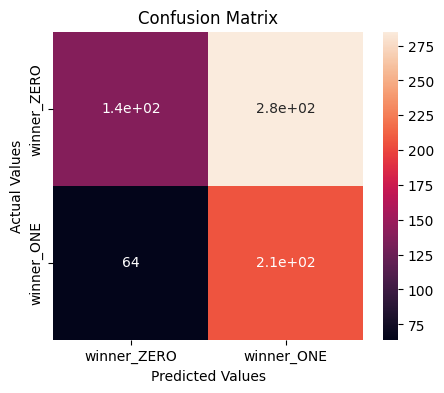

classification_report
               precision    recall  f1-score   support

           0       0.68      0.33      0.44       423
           1       0.42      0.76      0.54       270

    accuracy                           0.50       693
   macro avg       0.55      0.54      0.49       693
weighted avg       0.58      0.50      0.48       693

Epoch 1/7
41/41 [==============================] - 5s 57ms/step - loss: 0.6483 - accuracy: 0.6127 - val_loss: 0.5665 - val_accuracy: 0.7716
Epoch 2/7
41/41 [==============================] - 1s 32ms/step - loss: 0.3250 - accuracy: 0.9028 - val_loss: 0.4581 - val_accuracy: 0.7963
Epoch 3/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0931 - accuracy: 0.9653 - val_loss: 0.3205 - val_accuracy: 0.8889
Epoch 4/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0228 - accuracy: 0.9938 - val_loss: 0.4882 - val_accuracy: 0.8951
Epoch 5/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0114 - accuracy:

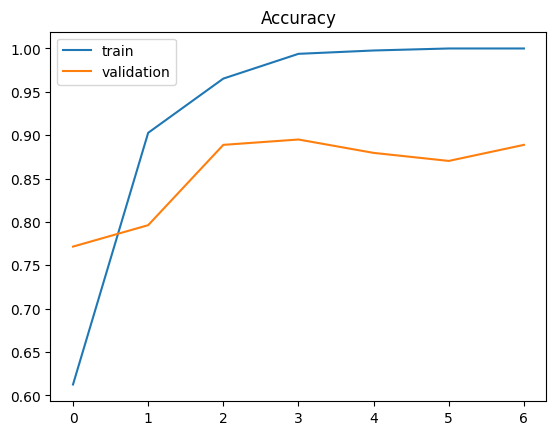

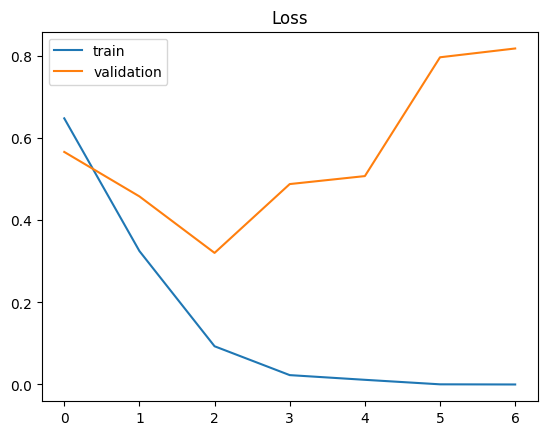

Testing model : /n
17/17 [==============================] - 0s 13ms/step - loss: 3.8668 - accuracy: 0.5481
Test set
  Loss: 3.867
  Accuracy: 0.548
22/22 [==============================] - 1s 15ms/step


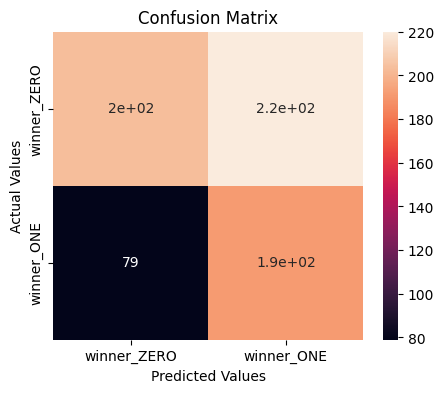

classification_report
               precision    recall  f1-score   support

           0       0.72      0.48      0.58       423
           1       0.46      0.71      0.56       270

    accuracy                           0.57       693
   macro avg       0.59      0.59      0.57       693
weighted avg       0.62      0.57      0.57       693

Epoch 1/7
41/41 [==============================] - 4s 50ms/step - loss: 0.6610 - accuracy: 0.6250 - val_loss: 0.5219 - val_accuracy: 0.7994
Epoch 2/7
41/41 [==============================] - 1s 33ms/step - loss: 0.2707 - accuracy: 0.8997 - val_loss: 0.3234 - val_accuracy: 0.8642
Epoch 3/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0679 - accuracy: 0.9792 - val_loss: 0.2490 - val_accuracy: 0.9321
Epoch 4/7
41/41 [==============================] - 1s 32ms/step - loss: 0.0216 - accuracy: 0.9938 - val_loss: 0.3682 - val_accuracy: 0.8765
Epoch 5/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0044 - accuracy:

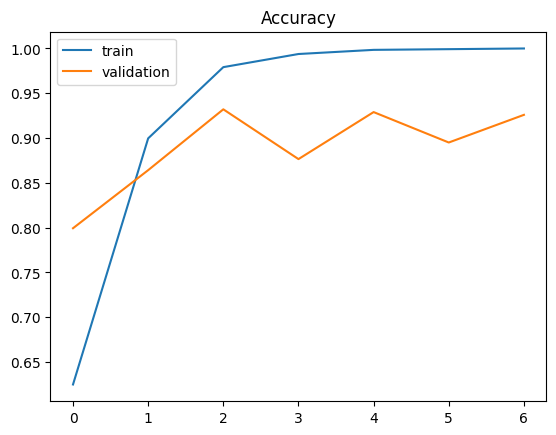

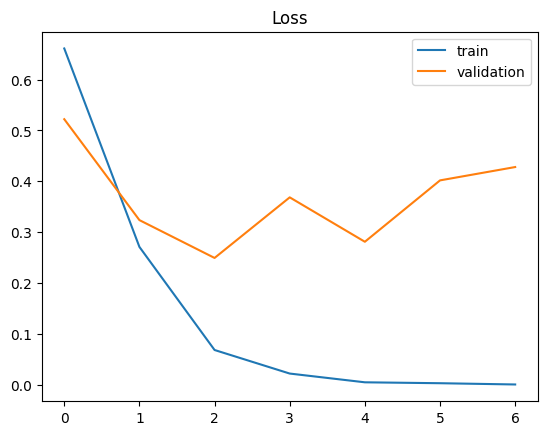

Testing model : /n
17/17 [==============================] - 0s 13ms/step - loss: 3.8204 - accuracy: 0.4852
Test set
  Loss: 3.820
  Accuracy: 0.485
22/22 [==============================] - 1s 11ms/step


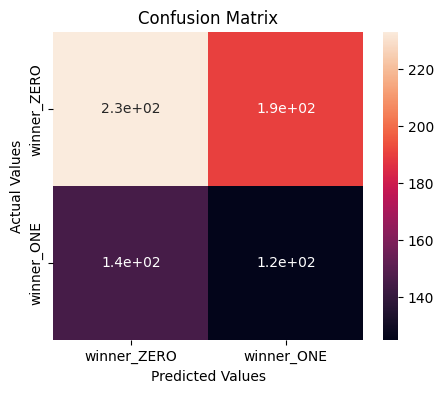

classification_report
               precision    recall  f1-score   support

           0       0.62      0.55      0.58       423
           1       0.40      0.46      0.43       270

    accuracy                           0.52       693
   macro avg       0.51      0.51      0.50       693
weighted avg       0.53      0.52      0.52       693

Epoch 1/7
41/41 [==============================] - 4s 57ms/step - loss: 0.6499 - accuracy: 0.6150 - val_loss: 0.4719 - val_accuracy: 0.7840
Epoch 2/7
41/41 [==============================] - 2s 39ms/step - loss: 0.2832 - accuracy: 0.9159 - val_loss: 0.3948 - val_accuracy: 0.8272
Epoch 3/7
41/41 [==============================] - 1s 33ms/step - loss: 0.1832 - accuracy: 0.9568 - val_loss: 0.7031 - val_accuracy: 0.8056
Epoch 4/7
41/41 [==============================] - 1s 33ms/step - loss: 0.0688 - accuracy: 0.9838 - val_loss: 0.3329 - val_accuracy: 0.8673
Epoch 5/7
41/41 [==============================] - 2s 43ms/step - loss: 0.0087 - accuracy:

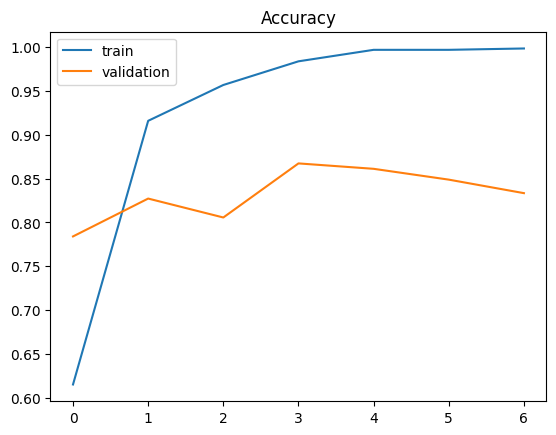

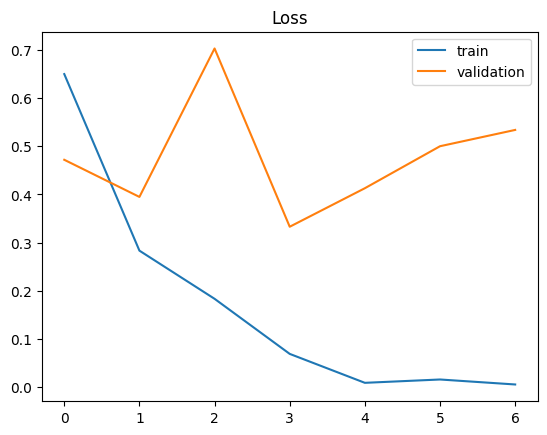

Testing model : /n
17/17 [==============================] - 0s 14ms/step - loss: 2.3254 - accuracy: 0.4833
Test set
  Loss: 2.325
  Accuracy: 0.483
22/22 [==============================] - 1s 12ms/step


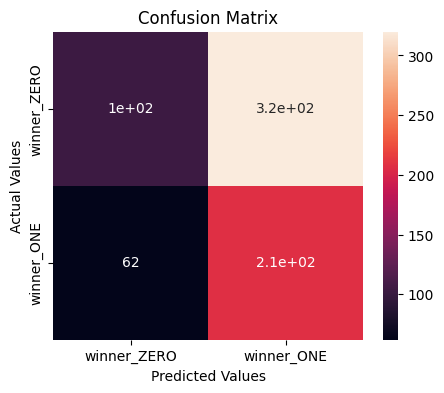

classification_report
               precision    recall  f1-score   support

           0       0.62      0.24      0.35       423
           1       0.39      0.77      0.52       270

    accuracy                           0.45       693
   macro avg       0.51      0.51      0.44       693
weighted avg       0.53      0.45      0.42       693

Acuuracy results of the 4 models :  [0.4963924963924964, 0.5685425685425686, 0.5165945165945166, 0.44877344877344877]
Avrage accuracy of this probability = 0.5075757575757576


In [64]:
#  preprocessing-  Balancing -    Anonymisation (8)

dff=df
dff_pred=df_pred

dff = balancing_func(dff)

for i in range (len(dff)):
    dff['Facts'].iloc[i] = anonymisation(dff['Facts'].iloc[i] , dff['first_party'].iloc[i] , dff['second_party'].iloc[i])

for i in range (len(dff_pred)):
    dff_pred['Facts'].iloc[i] = anonymisation(dff_pred['Facts'].iloc[i], dff_pred['first_party'].iloc[i] , dff_pred['second_party'].iloc[i])

dff = preprocessing(dff)
dff_pred = preprocessing(dff_pred)


#-----------------------------------

train_1,test_1,train_2,test_2,train_3,test_3,train_4,test_4 = K_fold(dff)

#----------------------------------

x_1 , y_1 = padding_df(train_1)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1,y_1, test_size = 0.2, random_state = 42)

x_test_1 , y_test_1 = padding_df(test_1)

x_2 , y_2 = padding_df(train_2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2,y_2, test_size = 0.2, random_state = 42)

x_test_2 , y_test_2 = padding_df(test_2)

x_3 , y_3 = padding_df(train_3)
x_train_3 , x_val_3, y_train_3, y_val_3 = train_test_split(x_3,y_3, test_size = 0.2, random_state = 42)

x_test_3 , y_test_3 = padding_df(test_3)

x_4 , y_4 = padding_df(train_4)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_4,y_4, test_size = 0.2, random_state = 42)

x_test_4 , y_test_4 = padding_df(test_4)

#------------------------------------
x_prediction , target_labels = padding_df(dff_pred)

acc_result = []

for i in range (4):
    
    if i == 0 :
        the_model_8_1 = creating_model( x_train_1 , y_train_1 , x_val_1 , y_val_1, x_test_1 , y_test_1)
        
        y_predict = the_model_8_1.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 1 :
        the_model_8_2 = creating_model( x_train_2 , y_train_2 , x_val_2 , y_val_2, x_test_2 , y_test_2)
        
        y_predict = the_model_8_2.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 2 :
        the_model_8_3 = creating_model( x_train_3 , y_train_3 , x_val_3 , y_val_3, x_test_3 , y_test_3)
        
        y_predict = the_model_8_3.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
    if i == 3 :
        the_model_8_4 = creating_model( x_train_4 , y_train_4 , x_val_4 , y_val_4, x_test_4 , y_test_4)
        
        y_predict = the_model_8_4.predict(x_prediction)
        y_predict = np.where(y_predict > 0.5, 1, 0)
    
        cm = confusion_matrix(target_labels,y_predict)
        cm_df = pd.DataFrame(cm,index = ['winner_ZERO','winner_ONE'], columns = ['winner_ZERO','winner_ONE'])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
        print('classification_report\n',classification_report(target_labels,y_predict))
        report = classification_report(target_labels,y_predict,output_dict=True)
        acc_result.append(report['accuracy'])
    
print('Acuuracy results of the 4 models : ',acc_result)
print('Avrage accuracy of this probability =' , sum(acc_result)/len(acc_result))

probabilities.append(sum(acc_result)/len(acc_result))


In [65]:
probabilities

[0.5497835497835498,
 0.5616883116883117,
 0.5057720057720058,
 0.5317460317460317,
 0.5515873015873016,
 0.5339105339105339,
 0.5018037518037518,
 0.5075757575757576]

In [70]:
from google.colab import drive 
drive.mount('/content/gdrive')
upload_model=the_model_2_2.save('/content/gdrive/MyDrive/LSTM__best_MODEL.h5')

Mounted at /content/gdrive
